<a href="https://colab.research.google.com/github/1am-Fida/skripsi/blob/main/Lorenz84.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Model    SMAPE   RMSE

FFT      87.57   0.58

ARIMA    99.63   0.58

Ensem    71.97

RF       80.24   0.51

###Install

In [1]:
pip install dysts

In [2]:
pip install statsmodels

In [3]:
pip install nolds

In [4]:
pip install darts

In [5]:
import torch, numpy as np

# Kalau saya sukanya cek versi dan apakah PyTorch (atau tensorflow) sudah dapat mengakses GPU atau belum
print("Using Numpy and Pytorch versions = {}, {}".format(np.__version__, torch.__version__))
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print('Using device:', device, end=', ')
if device.type == 'cuda': #Additional Info when using cuda
    print(torch.cuda.get_device_name(0))
    print('Currently Memory Allocated, Cached =', round(torch.cuda.memory_allocated(0)/1024**3,1), 'GB, ', round(torch.cuda.memory_reserved(0)/1024**3,1), 'GB')

Using Numpy and Pytorch versions = 1.22.4, 2.0.1+cu118
Using device: cpu, 

### Data

In [6]:
from dysts.datasets import load_dataset
import pandas as pd
import darts
import matplotlib.pyplot as plt
from darts.models import RandomForest,FFT,ARIMA,AutoARIMA,StatsForecastAutoARIMA,NaiveDrift,ExponentialSmoothing,Croston,StatsForecastAutoETS,StatsForecastAutoTheta,FourTheta,RegressionEnsembleModel
from darts.metrics import mape, smape, rmse
import warnings; warnings.simplefilter('ignore'); warnings.filterwarnings('ignore', module='darts'); warnings.filterwarnings('ignore', module='pandas')
import sys
from darts import metrics
from darts.utils.utils import TrendMode,ModelMode,SeasonalityMode
np.random.seed(1)

In [7]:
data = 'Lorenz84'
train_ = load_dataset(subsets="train", data_format="pandas", univariate=True, standardize=True).loc[data]
test_ = load_dataset(subsets="test", data_format="pandas", univariate=True, standardize=True).loc[data]

In [8]:
df = pd.concat([train_, test_], ignore_index=True) # , keys=["Train", "Test", "Validation"]
df.drop(['id'], axis=1, inplace=True)
df = df[['values']]#sol[['time', 'values_0']]


In [9]:
df.head()

,values
0,0.334791
1,0.541438
2,0.774878
3,1.016596
4,1.234661


### exploratory data analys

In [10]:
(pd.concat([train_,test_],axis=0).reset_index()).describe()

,id,time,values
count,2000.0,2000.000000,2.000000e+03
mean,64.0,31.287780,-7.265299e-16
std,0.0,18.086604,1.000250e+00
min,64.0,0.000000,-1.639283e+00
25%,64.0,15.643890,-8.246416e-01
50%,64.0,31.287780,-7.692325e-02
75%,64.0,46.931670,7.706944e-01
max,64.0,62.575560,2.219264e+00


<Axes: >

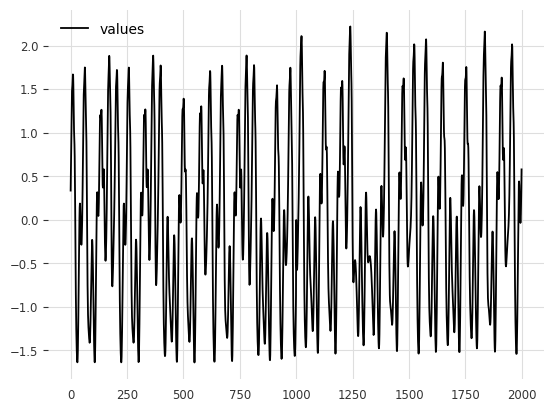

In [11]:
df.plot()

In [12]:
import statsmodels.api as sm

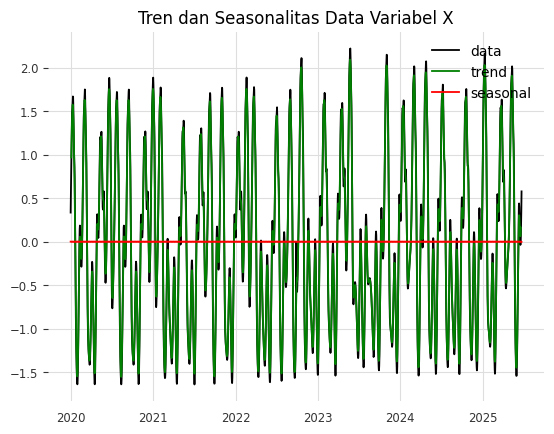

In [13]:
series_x = list(pd.concat([train_['values'], test_['values']], ignore_index=True))
date_rng = pd.date_range(start='1/1/2020', periods=2000)
series_x = pd.DataFrame(series_x, index=date_rng)
decomposition = sm.tsa.seasonal_decompose(series_x, model='additive')

plt.title('Tren dan Seasonalitas Data Variabel X')
plt.plot(series_x, label='data')
plt.plot(decomposition.trend, color='green', label='trend')
plt.plot(decomposition.seasonal, color='red', label='seasonal')
plt.legend(loc='upper right')
plt.show()

In [14]:
result = sm.tsa.adfuller(series_x)
# Menampilkan hasil uji ADF
print('ADF Statistic:', result[0])
print('p-value:', result[1])
print('Critical Values:')
for key, value in result[4].items():
    print(f'{key}: {value}')

ADF Statistic: -9.510277873069352
p-value: 3.2634484008694047e-16
Critical Values:
1%: -3.4336419856688276
5%: -2.862994217611322
10%: -2.567544164035933


**nolds**

In [15]:
import numpy as np
import nolds
largest_lyap = nolds.lyap_r(train_['values'])

entro = nolds.sampen(train_['values'])

print("lyapunov",largest_lyap)
print("entrophy",entro)

lyapunov 0.013892165969188942
entrophy 0.4526177895647776


In [16]:
#min_params = df[['values']].min()
#max_params = df[['values']].max()

#df[['values']] = (df[['values']] - min_params) / (max_params- min_params)

**split data becoming data train and test**

In [17]:
def df2series(df, cols):
    for i, col in enumerate(df[cols].columns):
        if i==0:
            series = darts.TimeSeries.from_dataframe(df, time_col=None, value_cols=col)
        else:
            series = series.stack(darts.TimeSeries.from_dataframe(df, time_col=None, value_cols=col))
    return series

cols = ['values'] # Silahkan rename jadi x, y, z


all = df2series(df, cols)
train, test = all.split_after(0.975)
print('Data train',len(train), '\nData test',len(test))

Data train 1950 
Data test 50


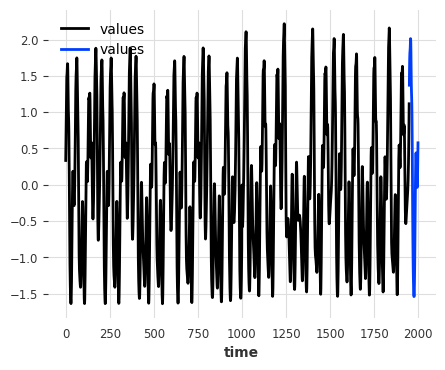

In [18]:
plt.figure(figsize=(5,4))
train['values'].plot()
test['values'].plot()

###RandomForest

In [ ]:
def RF(data, model, pVal=0.05, n_jobs=8, verbose_=False, metric_='smape'):

    parameters = {
        "lags": list(range(2, 13)), # list(range(2, 13)),
        "output_chunk_length" : [20, 25, 30],#[10, 15, 20, 25]
        "n_estimators":[25, 50, 75, 100], #10, 25, 50 list(range(10,110,10))
        "random_state":[0]
        }

    train, val = data.split_after(1-pVal)
    res = model.gridsearch(
        parameters=parameters,
        series=train,
        val_series=val,
        start=0.1,  # starting point in training set
        last_points_only=False,
        metric=getattr(metrics, metric_),
        reduction=np.mean,
        n_jobs=n_jobs,
        n_random_samples=None,# 0.99 % of full search space to evaluate
        verbose=verbose_,
    )
    return res

In [ ]:
model, bestparams, bestMetric_ = RF(train, RandomForest)
print("BestParameters", bestparams)
print("bestMetric_", bestMetric_)
# ===================== Training, Forecast & BackTest for Cross Validation=============================
print("GridSearch Finished,Training Best Model ... ", flush=True)
model.fit(train)
forecast_ = model.predict(len(test))
smape_ = darts.metrics.smape(test, forecast_)
rmse_ = darts.metrics.rmse(test, forecast_)
print("Pada data test RMSE={}, sMAPE={} ".format(rmse_, smape_), flush=True)

In [ ]:
test['values'].plot(label='aktual x')

forecast_['values'].plot(label='Forecast')
plt.show()

cross validation

In [ ]:
# ===================== Forecast & BackTest for Cross Validation=============================
print("Starting Backtest (Expanding Window) Cross Validation ...", flush=True)
model, bestparams, bestMetric_ = RF(train, RandomForest)

In [ ]:
print("Starting Backtest (Expanding Window) Cross Validation ...", flush=True)
backTest = model.historical_forecasts(all, start=.9725, forecast_horizon=5)

print("Backtest Finished", flush=True)
# ===================== Evaluate =============================

In [ ]:
print(len(backTest))

In [ ]:
all[-len(backTest)-100:].plot()
backTest.plot(label='backtest (n=10)')

In [ ]:
smape_ = darts.metrics.smape(all, backTest)
rmse_ = darts.metrics.rmse(all, backTest)
print("Hasil Cross Validasi RMSE={}, sMAPE={} ".format(rmse_, smape_), flush=True)

### FFT

In [ ]:
from darts.models import FFT

In [ ]:
def SFAETS(data, model, pVal=0.05, n_jobs=8, verbose_=False, metric_='smape'):

    parameters = {
        "nr_freqs_to_keep" : [0,1,2,3],
       #"required_matches":['month','day',None],
        "trend":['poly', 'exp', None],
        "trend_poly_degree" : [0,1,2,3],

        #"random_state":[0],
    }

    train, val = data.split_after(1-pVal)
    res = model.gridsearch(
        parameters=parameters,
        series=train,
        val_series=val,
        start=0.1,  # starting point in training set
        last_points_only=False,
        metric=getattr(metrics, metric_),
        reduction=np.mean,
        n_jobs=n_jobs,
        n_random_samples=None,# 0.99 % of full search space to evaluate
        verbose=verbose_,
    )
    return res

In [ ]:
model, bestparams, bestMetric = SFAETS(train, FFT)
print("BestParameters", bestparams)
print("bestMetric_", bestMetric)
# ===================== Training, Forecast & BackTest for Cross Validation=============================
print("GridSearch Finished,Training Best Model ... ", flush=True)
model.fit(train)
forecast= model.predict(len(test))
smape_ = darts.metrics.smape(test, forecast)
rmse_ = darts.metrics.rmse(test, forecast)
print("Pada data test RMSE={}, sMAPE={} ".format(rmse_, smape_), flush=True)

BestParameters {'nr_freqs_to_keep': 0, 'trend': 'poly', 'trend_poly_degree': 0}
bestMetric_ 121.52239028055492
GridSearch Finished,Training Best Model ... 
Pada data test RMSE=0.5868140877739388, sMAPE=87.57447355191242 


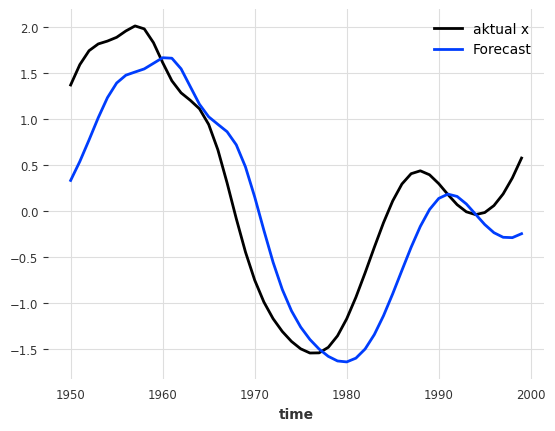

In [ ]:
test['values'].plot(label='aktual x')
forecast['values'].plot(label='Forecast')
plt.show()

**cross validation**

In [ ]:
# ===================== Forecast & BackTest for Cross Validation=============================
print("Starting Backtest (Expanding Window) Cross Validation ...", flush=True)
model, bestparams, bestMetric = SFAETS(train, FFT)

Starting Backtest (Expanding Window) Cross Validation ...


In [ ]:
print("Starting Backtest (Expanding Window) Cross Validation ...", flush=True)
backTest = model.historical_forecasts(all, start=.9725, forecast_horizon=5)

print("Backtest Finished", flush=True)
# ===================== Evaluate =============================

Starting Backtest (Expanding Window) Cross Validation ...
Backtest Finished


In [ ]:
print(len(backTest))

52


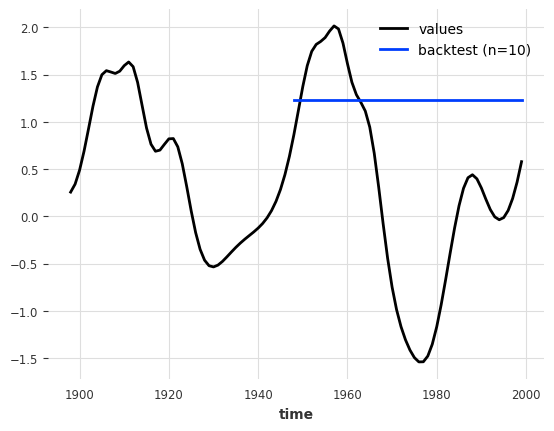

In [ ]:
#all[-len(backTest)-100:].plot()
all[-len(backTest)-50:].plot()
backTest.plot(label='backtest (n=10)')

In [ ]:
smape_ = darts.metrics.smape(all, backTest)
rmse_ = darts.metrics.rmse(all, backTest)
print("Hasil Cross Validasi RMSE={}, sMAPE={} ".format(rmse_, smape_), flush=True)

Hasil Cross Validasi RMSE=1.4495234514074977, sMAPE=119.7053790061557 


### AutoARIMA

In [ ]:
def AA(data, model, pVal=0.05, n_jobs=8, verbose_=False, metric_='smape'):

    parameters = {
        #'p':range(0,3),
        #'d':range(0,3),
        #'q':range(0,3),
        #'start_p':[1,2,3],
        #'start_d':[1,2,3],
        #'max_p':[1,2,3],
        #'max_d':[1,2,3],
        #'max_q':[2,3],
        #"random_state":[0],
    }

    train, val = data.split_after(1-pVal)
    res = model.gridsearch(
        parameters=parameters,
        series=train,
        val_series=val,
        start=0.1,  # starting point in training set
        last_points_only=False,
        metric=getattr(metrics, metric_),
        reduction=np.mean,
        n_jobs=n_jobs,
        n_random_samples=None,# 0.99 % of full search space to evaluate
        verbose=verbose_,
    )
    return res

In [ ]:
model, bestparams, bestMetric = AA(train, AutoARIMA)
print("BestParameters", bestparams)
print("bestMetric_", bestMetric)
# ===================== Training, Forecast & BackTest for Cross Validation=============================
print("GridSearch Finished,Training Best Model ... ", flush=True)
model.fit(train)
forecast= model.predict(len(test))
smape_ = darts.metrics.smape(test, forecast)
rmse_ = darts.metrics.rmse(test, forecast)
print("Pada data test RMSE={}, sMAPE={} ".format(rmse_, smape_), flush=True)

BestParameters {}
bestMetric_ 177.48024853950594
GridSearch Finished,Training Best Model ... 
Pada data test RMSE=0.5644439450183153, sMAPE=94.77237649787399 


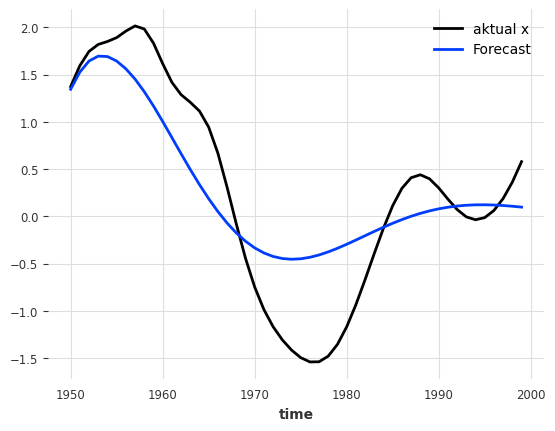

In [ ]:
test['values'].plot(label='aktual x')
forecast['values'].plot(label='Forecast')
plt.show()

**cross validation**

In [ ]:
# ===================== Forecast & BackTest for Cross Validation=============================
print("Starting Backtest (Expanding Window) Cross Validation ...", flush=True)
model, bestparams, bestMetric = AA(train, AutoARIMA)

Starting Backtest (Expanding Window) Cross Validation ...


In [ ]:
print("Starting Backtest (Expanding Window) Cross Validation ...", flush=True)
backTest = model.historical_forecasts(all, start=.9725, forecast_horizon=5)

print("Backtest Finished", flush=True)
# ===================== Evaluate =============================

Starting Backtest (Expanding Window) Cross Validation ...
Backtest Finished


In [ ]:
print(len(backTest))

52


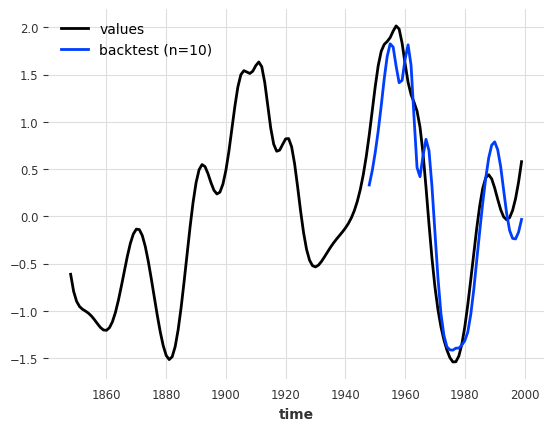

In [ ]:
all[-len(backTest)-100:].plot()
backTest.plot(label='backtest (n=10)')

In [ ]:
smape_ = darts.metrics.smape(all, backTest)
rmse_ = darts.metrics.rmse(all, backTest)
print("Hasil Cross Validasi RMSE={}, sMAPE={} ".format(rmse_, smape_), flush=True)

Hasil Cross Validasi RMSE=0.39722677177467663, sMAPE=71.8735049674592 


### ARIMA

In [ ]:
for i in list(range(2)):
  print(i)

0
1


In [ ]:
from darts.models import ARIMA

In [ ]:
def AR(data, model, pVal=0.05, n_jobs=8, verbose_=False, metric_='smape'):

    parameters = {
        'p':[2,3],#list(range(2,4)),
        'd':[0],#list(range(2)),#[0]
        'q':[3,4,5,6],#list(range(3,7)),
        "random_state":[0],
    }

    train, val = data.split_after(1-pVal)
    res = model.gridsearch(
        parameters=parameters,
        series=train,
        val_series=val,
        start=0.1,  # starting point in training set
        last_points_only=False,
        metric=getattr(metrics, metric_),
        reduction=np.mean,
        n_jobs=n_jobs,
        n_random_samples=None,# 0.99 % of full search space to evaluate
        verbose=verbose_,
    )
    return res

In [ ]:
model, bestparams, bestMetric = AR(train, ARIMA)
print("BestParameters", bestparams)
print("bestMetric_", bestMetric)
# ===================== Training, Forecast & BackTest for Cross Validation=============================
print("GridSearch Finished,Training Best Model ... ", flush=True)
model.fit(train)
forecast= model.predict(len(test))
smape_ = darts.metrics.smape(test, forecast)
rmse_ = darts.metrics.rmse(test, forecast)
print("Pada data test RMSE={}, sMAPE={} ".format(rmse_, smape_), flush=True)

BestParameters {'p': 3, 'd': 0, 'q': 5, 'random_state': 0}
bestMetric_ 173.15452543556492
GridSearch Finished,Training Best Model ... 
Pada data test RMSE=0.5869208144976159, sMAPE=99.63744258581163 


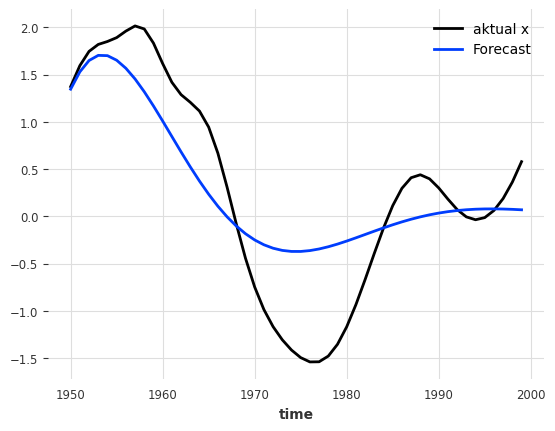

In [ ]:
test['values'].plot(label='aktual x')
forecast['values'].plot(label='Forecast')
plt.show()

**cross validation**

In [ ]:
# ===================== Forecast & BackTest for Cross Validation=============================
print("Starting Backtest (Expanding Window) Cross Validation ...", flush=True)
model, bestparams, bestMetric = AR(train, ARIMA)

Starting Backtest (Expanding Window) Cross Validation ...


In [ ]:
print("Starting Backtest (Expanding Window) Cross Validation ...", flush=True)
backTest = model.historical_forecasts(all, start=.9725, forecast_horizon=5)

print("Backtest Finished", flush=True)
# ===================== Evaluate =============================

Starting Backtest (Expanding Window) Cross Validation ...
Backtest Finished


In [ ]:
print(len(backTest))

52


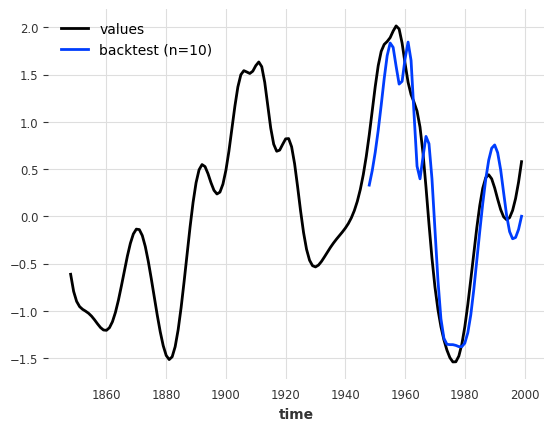

In [ ]:
#test['values'].plot()
#backTest.plot()
all[-len(backTest)-100:].plot()
backTest.plot(label='backtest (n=10)')

In [ ]:
smape_ = darts.metrics.smape(all, backTest)
rmse_ = darts.metrics.rmse(all, backTest)
print("Hasil Cross Validasi RMSE={}, sMAPE={} ".format(rmse_, smape_), flush=True)

Hasil Cross Validasi RMSE=0.40193151042562375, sMAPE=72.23056695030763 


### StatForecastAUTOARIMA

In [ ]:
from darts.models import StatsForecastAutoARIMA

In [ ]:
def SFAA(data, model, pVal=0.05, n_jobs=8, verbose_=False, metric_='smape'):

    parameters = {

        #"random_state":[0],
    }

    train, val = data.split_after(1-pVal)
    res = model.gridsearch(
        parameters=parameters,
        series=train,
        val_series=val,
        start=0.1,  # starting point in training set
        last_points_only=False,
        metric=getattr(metrics, metric_),
        reduction=np.mean,
        n_jobs=n_jobs,
        n_random_samples=None,# 0.99 % of full search space to evaluate
        verbose=verbose_,
    )
    return res

In [ ]:
model, bestparams, bestMetric = SFAA(train, StatsForecastAutoARIMA)
print("BestParameters", bestparams)
print("bestMetric_", bestMetric)
# ===================== Training, Forecast & BackTest for Cross Validation=============================
print("GridSearch Finished,Training Best Model ... ", flush=True)
model.fit(train)
forecast= model.predict(len(test))
smape_ = darts.metrics.smape(test, forecast)
rmse_ = darts.metrics.rmse(test, forecast)
print("Pada data test RMSE={}, sMAPE={} ".format(rmse_, smape_), flush=True)

BestParameters {}
bestMetric_ 181.9118542049017
GridSearch Finished,Training Best Model ... 
Pada data test RMSE=0.6377400529192928, sMAPE=115.85053605870763 


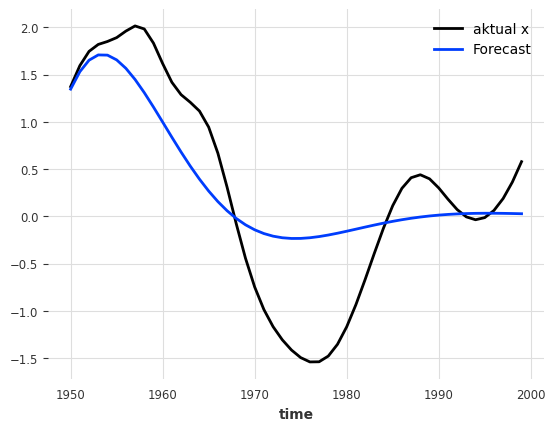

In [ ]:
test['values'].plot(label='aktual x')
forecast['values'].plot(label='Forecast')
plt.show()

**cross validation**

In [ ]:
# ===================== Forecast & BackTest for Cross Validation=============================
print("Starting Backtest (Expanding Window) Cross Validation ...", flush=True)
model, bestparams, bestMetric = SFAA(train, StatsForecastAutoARIMA)

Starting Backtest (Expanding Window) Cross Validation ...


In [ ]:
print("Starting Backtest (Expanding Window) Cross Validation ...", flush=True)
backTest = model.historical_forecasts(all, start=.9725, forecast_horizon=5)

print("Backtest Finished", flush=True)
# ===================== Evaluate =============================

Starting Backtest (Expanding Window) Cross Validation ...
Backtest Finished


In [ ]:
print(len(backTest))

52


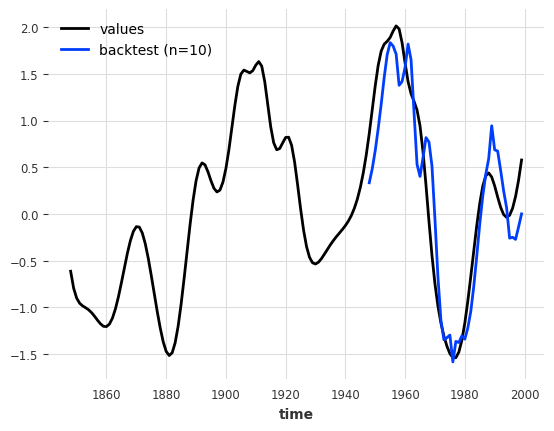

In [ ]:
all[-len(backTest)-100:].plot()
backTest.plot(label='backtest (n=10)')

In [ ]:
smape_ = darts.metrics.smape(all, backTest)
rmse_ = darts.metrics.rmse(all, backTest)
print("Hasil Cross Validasi RMSE={}, sMAPE={} ".format(rmse_, smape_), flush=True)

Hasil Cross Validasi RMSE=0.4096321996460999, sMAPE=72.39551490308921 


###exponential smoothing

In [ ]:
from darts.models import ExponentialSmoothing
from darts.utils.utils import ModelMode, SeasonalityMode

def ES(data, model, pVal=0.05, n_jobs=8, verbose_=False, metric_='smape'):

    parameters = {
        "trend": [ModelMode.ADDITIVE,None],#ModelMode.MULTIPLICATIVE,
        "damped" : [False],#True
        "seasonal" : [SeasonalityMode.ADDITIVE,None],#SeasonalityMode.MULTIPLICATIVE,
        "random_state":[0],
    }

    train, val = data.split_after(1-pVal)
    res = model.gridsearch(
        parameters=parameters,
        series=train,
        val_series=val,
        start=0.1,  # starting point in training set
        last_points_only=False,
        metric=getattr(metrics, metric_),
        reduction=np.mean,
        n_jobs=n_jobs,
        n_random_samples=None,# 0.99 % of full search space to evaluate
        verbose=verbose_,
    )
    return res

In [ ]:
model, bestparams, bestMetric = ES(train, ExponentialSmoothing)
print("BestParameters", bestparams)
print("bestMetric_", bestMetric)
# ===================== Training, Forecast & BackTest for Cross Validation=============================
print("GridSearch Finished,Training Best Model ... ", flush=True)
model.fit(train)
forecast = model.predict(len(test))
smape_ = darts.metrics.smape(test, forecast)
rmse_ = darts.metrics.rmse(test, forecast)
print("Pada data test RMSE={}, sMAPE={} ".format(rmse_, smape_), flush=True)

BestParameters {'trend': None, 'damped': False, 'seasonal': None, 'random_state': 0}
bestMetric_ 126.14302271241343
GridSearch Finished,Training Best Model ... 
Pada data test RMSE=1.4019219644683398, sMAPE=124.10372665920345 


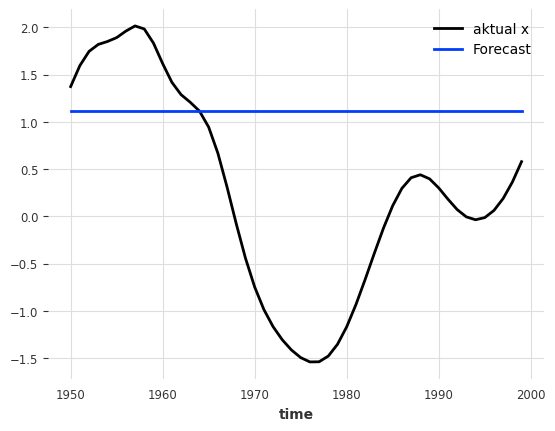

In [ ]:
test['values'].plot(label='aktual x')

forecast['values'].plot(label='Forecast')
plt.show()

**cross validation**

In [ ]:
# ===================== Forecast & BackTest for Cross Validation=============================
print("Starting Backtest (Expanding Window) Cross Validation ...", flush=True)
model, bestparams, bestMetric = ES(train, ExponentialSmoothing)

Starting Backtest (Expanding Window) Cross Validation ...


In [ ]:
print("Starting Backtest (Expanding Window) Cross Validation ...", flush=True)
backTest = model.historical_forecasts(all, start=.9725, forecast_horizon=5)

print("Backtest Finished", flush=True)
# ===================== Evaluate =============================

Starting Backtest (Expanding Window) Cross Validation ...
Backtest Finished


In [ ]:
print(len(backTest))

52


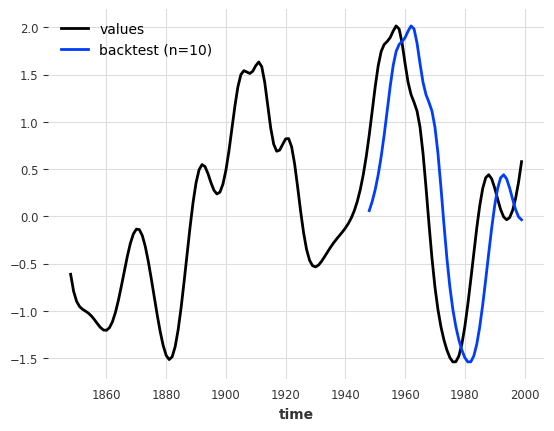

In [ ]:
all[-len(backTest)-100:].plot()
backTest.plot(label='backtest (n=10)')

In [ ]:
smape_ = darts.metrics.smape(all, backTest)
rmse_ = darts.metrics.rmse(all, backTest)
print("Hasil Cross Validasi RMSE={}, sMAPE={} ".format(rmse_, smape_), flush=True)

Hasil Cross Validasi RMSE=0.843261618964075, sMAPE=108.36185843460309 


### Croston

In [ ]:
from darts.models import Croston

In [ ]:
def Cr(data, model, pVal=0.05, n_jobs=8, verbose_=False, metric_='smape'):

    parameters = {
        "version" : ['classic',
                     'optimized',
                     'sba','tsb'],
       "alpha_d":[0.0,0.01,0.05],
        "alpha_p":[0.0,0.01,0.05]
        #"random_state":[0],
    }

    train, val = data.split_after(1-pVal)
    res = model.gridsearch(
        parameters=parameters,
        series=train,
        val_series=val,
        start=0.1,  # starting point in training set
        last_points_only=False,
        metric=getattr(metrics, metric_),
        reduction=np.mean,
        n_jobs=n_jobs,
        n_random_samples=None,# 0.99 % of full search space to evaluate
        verbose=verbose_,
    )
    return res

In [ ]:
model, bestparams, bestMetric = Cr(train, Croston)
print("BestParameters", bestparams)
print("bestMetric_", bestMetric)
# ===================== Training, Forecast & BackTest for Cross Validation=============================
print("GridSearch Finished,Training Best Model ... ", flush=True)
model.fit(train)
forecast= model.predict(len(test))
smape_ = darts.metrics.smape(test, forecast)
rmse_ = darts.metrics.rmse(test, forecast)
print("Pada data test RMSE={}, sMAPE={} ".format(rmse_, smape_), flush=True)

BestParameters {'version': 'optimized', 'alpha_d': 0.0, 'alpha_p': 0.0}
bestMetric_ 135.68920340894758
GridSearch Finished,Training Best Model ... 
Pada data test RMSE=1.2029803768554064, sMAPE=127.78208250661332 


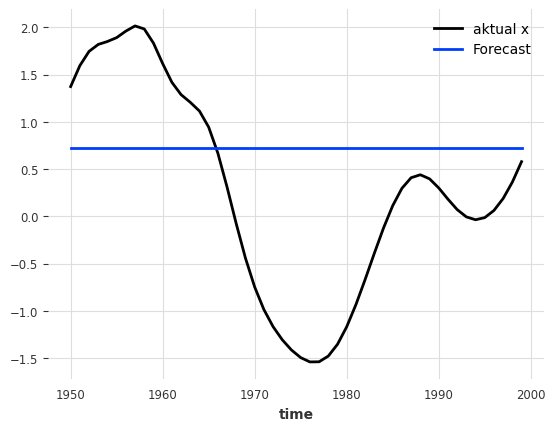

In [ ]:
test['values'].plot(label='aktual x')
forecast['values'].plot(label='Forecast')
plt.show()

**cross validation**

In [ ]:
# ===================== Forecast & BackTest for Cross Validation=============================
print("Starting Backtest (Expanding Window) Cross Validation ...", flush=True)
model, bestparams, bestMetric = Cr(train, Croston)

Starting Backtest (Expanding Window) Cross Validation ...


In [ ]:
print("Starting Backtest (Expanding Window) Cross Validation ...", flush=True)
backTest = model.historical_forecasts(all, start=.9725, forecast_horizon=5)

print("Backtest Finished", flush=True)
# ===================== Evaluate =============================

Starting Backtest (Expanding Window) Cross Validation ...
Backtest Finished


In [ ]:
print(len(backTest))

52


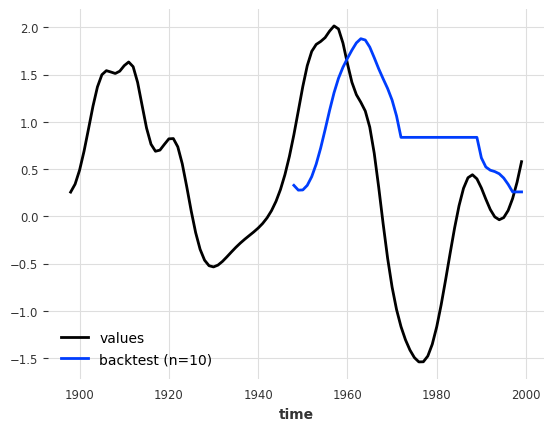

In [ ]:
#all[-len(backTest)-100:].plot()
all[-len(backTest)-50:].plot()
backTest.plot(label='backtest (n=10)')

In [ ]:
smape_ = darts.metrics.smape(all, backTest)
rmse_ = darts.metrics.rmse(all, backTest)
print("Hasil Cross Validasi RMSE={}, sMAPE={} ".format(rmse_, smape_), flush=True)

Hasil Cross Validasi RMSE=1.2728920995470878, sMAPE=124.69321490124636 


### NaiveDrift (Naive Baseline)

In [19]:
from darts.models import NaiveDrift

In [20]:
def Drft(data, model, pVal=0.05, n_jobs=8, verbose_=False, metric_='smape'):

    parameters = {

        #"random_state":[0],
    }

    train, val = data.split_after(1-pVal)
    res = model.gridsearch(
        parameters=parameters,
        series=train,
        val_series=val,
        start=0.1,  # starting point in training set
        last_points_only=False,
        metric=getattr(metrics, metric_),
        reduction=np.mean,
        n_jobs=n_jobs,
        n_random_samples=None,# 0.99 % of full search space to evaluate
        verbose=verbose_,
    )
    return res

In [21]:
model, bestparams, bestMetric = Drft(train, NaiveDrift)
print("BestParameters", bestparams)
print("bestMetric_", bestMetric)
# ===================== Training, Forecast & BackTest for Cross Validation=============================
print("GridSearch Finished,Training Best Model ... ", flush=True)
model.fit(train)
forecast= model.predict(len(test))
smape_ = darts.metrics.smape(test, forecast)
rmse_ = darts.metrics.rmse(test, forecast)
print("Pada data test RMSE={}, sMAPE={} ".format(rmse_, smape_), flush=True)

BestParameters {}
bestMetric_ 126.78674656490433
GridSearch Finished,Training Best Model ... 
Pada data test RMSE=1.4106017469728043, sMAPE=124.28696132179478 


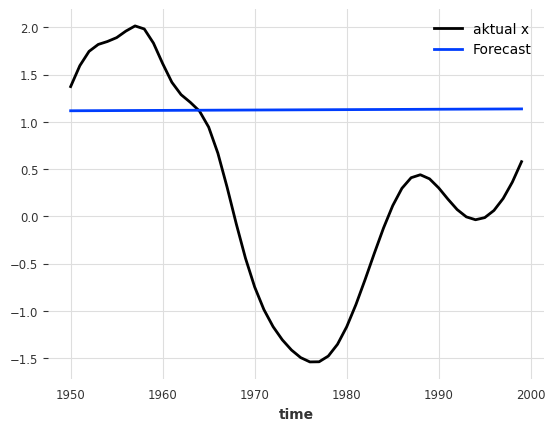

In [22]:
test['values'].plot(label='aktual x')
forecast['values'].plot(label='Forecast')
plt.show()

**cross validation**

In [23]:
# ===================== Forecast & BackTest for Cross Validation=============================
print("Starting Backtest (Expanding Window) Cross Validation ...", flush=True)
model, bestparams, bestMetric = Drft(train, NaiveDrift)

Starting Backtest (Expanding Window) Cross Validation ...


In [24]:
print("Starting Backtest (Expanding Window) Cross Validation ...", flush=True)
backTest = model.historical_forecasts(all, start=.9, forecast_horizon=10)

print("Backtest Finished", flush=True)
# ===================== Evaluate =============================

Starting Backtest (Expanding Window) Cross Validation ...
Backtest Finished


In [25]:
print(len(backTest))

192


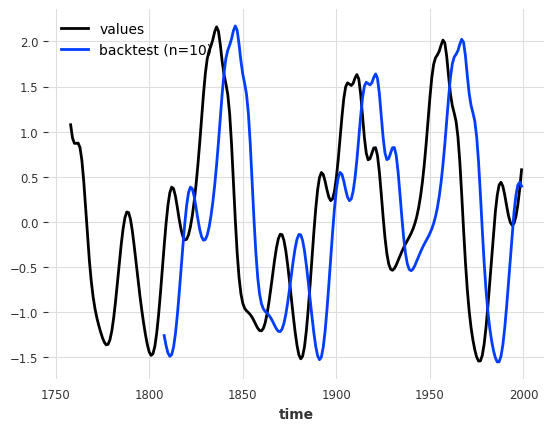

In [26]:
#all[-len(backTest)-100:].plot()
all[-len(backTest)-50:].plot()
backTest.plot(label='backtest (n=10)')

In [27]:
smape_ = darts.metrics.smape(all, backTest)
rmse_ = darts.metrics.rmse(all, backTest)
print("Hasil Cross Validasi RMSE={}, sMAPE={} ".format(rmse_, smape_), flush=True)

Hasil Cross Validasi RMSE=1.2509006288893543, sMAPE=133.7043020851005 


### StatsForecastAutoTheta

In [1]:
from darts.models import StatsForecastAutoTheta

ModuleNotFoundError: ignored

In [ ]:
def AT(data, model, pVal=0.05, n_jobs=8, verbose_=False, metric_='smape'):

    parameters = {
        'season_length':[0,3,12,60]

        #"random_state":[0],
    }

    train, val = data.split_after(1-pVal)
    res = model.gridsearch(
        parameters=parameters,
        series=train,
        val_series=val,
        start=0.1,  # starting point in training set
        last_points_only=False,
        metric=getattr(metrics, metric_),
        reduction=np.mean,
        n_jobs=n_jobs,
        n_random_samples=None,# 0.99 % of full search space to evaluate
        verbose=verbose_,
    )
    return res

In [ ]:
model, bestparams, bestMetric = AT(train, StatsForecastAutoTheta)
print("BestParameters", bestparams)
print("bestMetric_", bestMetric)
# ===================== Training, Forecast & BackTest for Cross Validation=============================
print("GridSearch Finished,Training Best Model ... ", flush=True)
model.fit(train)
forecast= model.predict(len(test))
smape_ = darts.metrics.smape(test, forecast)
rmse_ = darts.metrics.rmse(test, forecast)
print("Pada data test RMSE={}, sMAPE={} ".format(rmse_, smape_), flush=True)

In [ ]:
test['values'].plot(label='aktual x')
forecast['values'].plot(label='Forecast')
plt.show()

**cross validation**

In [ ]:
# ===================== Forecast & BackTest for Cross Validation=============================
print("Starting Backtest (Expanding Window) Cross Validation ...", flush=True)
model, bestparams, bestMetric = AT(train, StatsForecastAutoTheta)

In [ ]:
print("Starting Backtest (Expanding Window) Cross Validation ...", flush=True)
backTest = model.historical_forecasts(all, start=.9, forecast_horizon=10)

print("Backtest Finished", flush=True)
# ===================== Evaluate =============================

In [ ]:
print(len(backTest))

In [ ]:
all[-len(backTest)-100:].plot()
backTest.plot(label='backtest (n=10)')

In [ ]:
smape_ = darts.metrics.smape(all, backTest)
rmse_ = darts.metrics.rmse(all, backTest)
print("Hasil Cross Validasi RMSE={}, sMAPE={} ".format(rmse_, smape_), flush=True)

### StatForecast Auto ETS

In [ ]:
from darts.models import StatsForecastAutoETS

In [ ]:
def ETS(data, model, pVal=0.05, n_jobs=8, verbose_=False, metric_='smape'):

    parameters = {
        'season_length':[2,7],
        'model':['ZZZ', 'AAN','ANN','AZZ','AAZ'],
                #['ZZZ','AAA', 'AAN', 'ANA', 'ANN', 'MAA', 'MAN', 'MNA', 'MNN']
                 #'ANN','ANA','ANM','AAN','AAA','AAM','AAdN','AAdA','AAdM',
                 #'MNN','MNA','MNM','MAN','MAA','MAM','MAdN','MAdA','MAdM']
                 #['A','M'],['N','A','Ad'],['N','A','M']],
        #'seasonal': ['add', 'additive', 'mul', 'multiplicative']
        #"random_state":[0],
    }

    train, val = data.split_after(1-pVal)
    res = model.gridsearch(
        parameters=parameters,
        series=train,
        val_series=val,
        start=0.1,  # starting point in training set
        last_points_only=False,
        metric=getattr(metrics, metric_),
        reduction=np.mean,
        n_jobs=n_jobs,
        n_random_samples=None,# 0.99 % of full search space to evaluate
        verbose=verbose_,
    )
    return res

In [ ]:
model, bestparams, bestMetric = ETS(train, StatsForecastAutoETS)
print("BestParameters", bestparams)
print("bestMetric_", bestMetric)
# ===================== Training, Forecast & BackTest for Cross Validation=============================
print("GridSearch Finished,Training Best Model ... ", flush=True)
model.fit(train)
forecast= model.predict(len(test))
smape_ = darts.metrics.smape(test, forecast)
rmse_ = darts.metrics.rmse(test, forecast)
print("Pada data test RMSE={}, sMAPE={} ".format(rmse_, smape_), flush=True)

In [ ]:
test['values'].plot(label='aktual x')
forecast['values'].plot(label='Forecast')
plt.show()

**cross validation**

In [ ]:
# ===================== Forecast & BackTest for Cross Validation=============================
print("Starting Backtest (Expanding Window) Cross Validation ...", flush=True)
model, bestparams, bestMetric = ETS(train, StatsForecastAutoETS)

In [ ]:
print("Starting Backtest (Expanding Window) Cross Validation ...", flush=True)
backTest = model.historical_forecasts(all, start=.9, forecast_horizon=10)


print("Backtest Finished", flush=True)
# ===================== Evaluate =============================

In [ ]:
print(len(backTest))

In [ ]:
all[-len(backTest)-100:].plot()
backTest.plot(label='backtest (n=10)')

In [ ]:
smape_ = darts.metrics.smape(all, backTest)
rmse_ = darts.metrics.rmse(all, backTest)
print("Hasil Cross Validasi RMSE={}, sMAPE={} ".format(rmse_, smape_), flush=True)

### 4Theta

In [ ]:
def fort(data, model, pVal=0.05, n_jobs=8, verbose_=False, metric_='smape'):

    parameters = {
        "theta": [0,1],
        "seasonality_period" : [None],#True
        "season_mode" : [SeasonalityMode.ADDITIVE,SeasonalityMode.NONE],#SeasonalityMode.MULTIPLICATIVE,
        "model_mode" : [ModelMode.ADDITIVE],
        "trend_mode" : [TrendMode.EXPONENTIAL,TrendMode.LINEAR],
        'normalization' : [True,False],
        #"random_state":[0],
    }

    train, val = data.split_after(1-pVal)
    res = model.gridsearch(
        parameters=parameters,
        series=train,
        val_series=val,
        start=0.1,  # starting point in training set
        last_points_only=False,
        metric=getattr(metrics, metric_),
        reduction=np.mean,
        n_jobs=n_jobs,
        n_random_samples=None,# 0.99 % of full search space to evaluate
        verbose=verbose_,
    )
    return res

In [ ]:
model, bestparams, bestMetric = fort(train, FourTheta)
print("BestParameters", bestparams)
print("bestMetric_", bestMetric)
# ===================== Training, Forecast & BackTest for Cross Validation=============================
print("GridSearch Finished,Training Best Model ... ", flush=True)
model.fit(train)
forecast= model.predict(len(test))
smape_ = darts.metrics.smape(test, forecast)
rmse_ = darts.metrics.rmse(test, forecast)
print("Pada data test RMSE={}, sMAPE={} ".format(rmse_, smape_), flush=True)

In [ ]:
test['values'].plot(label='aktual x')
forecast['values'].plot(label='Forecast')
plt.show()

**cross validation**

In [ ]:
# ===================== Forecast & BackTest for Cross Validation=============================
print("Starting Backtest (Expanding Window) Cross Validation ...", flush=True)
model, bestparams, bestMetric = fort(train, FourTheta)

In [ ]:
print("Starting Backtest (Expanding Window) Cross Validation ...", flush=True)
backTest = model.historical_forecasts(all, start=.9, forecast_horizon=10)

print("Backtest Finished", flush=True)
# ===================== Evaluate =============================

In [ ]:
print(len(backTest))

In [ ]:
all[-len(backTest)-100:].plot()
backTest.plot(label='backtest (n=10)')

In [ ]:
smape_ = darts.metrics.smape(all, backTest)
rmse_ = darts.metrics.rmse(all, backTest)
print("Hasil Cross Validasi RMSE={}, sMAPE={} ".format(rmse_, smape_), flush=True)

## Regresi Ensemble

#### code

In [ ]:
from darts.metrics import smape, mape, mase, mae, mse, ope, r2_score, rmse, rmsle
from darts.utils.statistics import check_seasonality, plot_acf, plot_residuals_analysis
from darts.dataprocessing.transformers.boxcox import BoxCox
import time

In [ ]:
# compute accuracy metrics and processing time

def accuracy_metrics(act, forecast, resid):#, t_star
    sr = resid.pd_series()
    sa = act.pd_series()
    n_act = len(act)
    res_mape = mape(act, forecast)
    res_smape = smape(act, forecast)
    res_mae = mae(act, forecast)
    res_r2 = r2_score(act, forecast)
    res_rmse = rmse(act, forecast)
    res_rmsle = rmsle(act, forecast)
    res_pe = sr / sa
    res_rmspe = np.sqrt(np.sum(res_pe**2) / n_act)    # root mean square percentage error

    #res_time = time.perf_counter() - t_start

    res_mean = np.mean(sr)
    res_std = np.std(sr)                               # std error of the model = std deviation of the noise
    res_se = res_std / np.sqrt(n_act)                  # std error in estimating the mean
    res_sefc = np.sqrt(res_std + res_se**2)            # std error of the forecast

    res_accuracy = {"SMAPE" : res_smape,"MAPE":res_mape,"RMSE":res_rmse, "-R squared":-res_r2,
        "se": res_sefc} #, "time":res_time
    return res_accuracy

In [ ]:
## fit the chosen forecaster model and compute predictions

def eval_model(model):
    #t_start =  time.perf_counter()
    strmodel = str(model)[:30]
    print("beginning: " + strmodel)


    # fit the model and compute predictions
    n_val = len(test)
    res = model.fit(train)
    forecast = model.predict(n_val)


    # for naive forecast, concatenate seasonal fc with drift fc
    ##if model == m_stat:
    ##    if is_seasonal:
    ##        fc_drift = forecast
      ##      modelS = NaiveSeasonal(K=mseas)
       ##     modelS.fit(train)
         #### forecast = fc_drift + fc_seas - train.last_value()


    resid = forecast - test
    res_accuracy = accuracy_metrics(test, forecast, resid)#, t_start


    results = [forecast, res_accuracy]

    print("completed: " + strmodel + ":" + str(res_accuracy["time"]) + " sec")
    return results

#### FFT & ARIMA

In [ ]:
from darts.models import FFT
models_=[
        #StatsForecastAutoARIMA(),
        FFT(nr_freqs_to_keep=0,trend='poly',trend_poly_degree=0),
        ARIMA(p = 3, d= 0, q=5,random_state=0),
        #AutoARIMA(),
        #ExponentialSmoothing(trend=None, damped=False, seasonal=None, random_state=0),
        #RandomForest(lags= 12, output_chunk_length= 25, n_estimators= 50, random_state= 0),
        #NBEATSModel(input_chunk_length=5,output_chunk_length=5,random_state=0),
        #FourTheta(theta=0,seasonality_period = None, season_mode = SeasonalityMode.ADDITIVE, model_mode = ModelMode.ADDITIVE,trend_mode=TrendMode.EXPONENTIAL, normalization=True)
]

In [ ]:
# ensemble forecast evaluation function:
# the eval function calls the methods contained in the list 'models'

def ensemble_eval(train, test, models):
    #t_start =  time.perf_counter()
    n_train = 12                # use 50 observation to train the ensemble model
    n_val = len(test)            # forecast as many periods as are in the valuation dataset


    # compute predictions
    # ensemble_model = RegressionEnsembleModel(forecasting_models=models, regression_train_n_points=n_train)
    # new Jan 022: RegressionEnsembleModel class no longer accepts as argument the list "models" of previously instantiated models
    # instead, explicitly list each of the forecast methods
    ensemble_model = RegressionEnsembleModel(
                                forecasting_models=[
                                    #Prophet(),
                                    FFT(nr_freqs_to_keep=0,trend='poly',trend_poly_degree=0),
                                    #StatsForecastAutoARIMA(),
                                    #AutoARIMA(),
                                    ARIMA(p = 3, d= 0, q=5,random_state=0),
                                    #ExponentialSmoothing(trend=None, damped=False, seasonal=None, random_state=0),
                                    #RandomForest(lags= 12, output_chunk_length= 25, n_estimators= 50, random_state= 0),
                                    #NBEATSModel(input_chunk_length=5,output_chunk_length=5,random_state=0),
                                    #FourTheta(theta=0,seasonality_period = None, season_mode = SeasonalityMode.ADDITIVE, model_mode = ModelMode.ADDITIVE,trend_mode=TrendMode.EXPONENTIAL, normalization=True)
                                                        ],
                                regression_train_n_points=12,
                                #regression_model = RandomForest(lags=None,lags_future_covariates = [0], lags_past_covariates = None, output_chunk_length=12 ,add_encoders=None, n_estimators= 50, random_state= 0 )
                                )


    ensemble_model.fit(train)
    forecast = ensemble_model.predict(n_val)
    resid = forecast - test


    res_accuracy = accuracy_metrics(test, forecast, resid)#,t_start


    # plot the ensemble forecast
    #data.plot(label="actual") #kalau mau liat seluruh data
    test.plot(label="actual") # kalau mau liat perbandingan data test dgn forecast
    forecast.plot(label="Ensemble forecast")
    plt.title("SMAPE = {:.2f}%".format(res_accuracy["SMAPE"]))
    plt.legend();


    results = [forecast, res_accuracy]
    return results

Ensemble of all 2 forecasters:


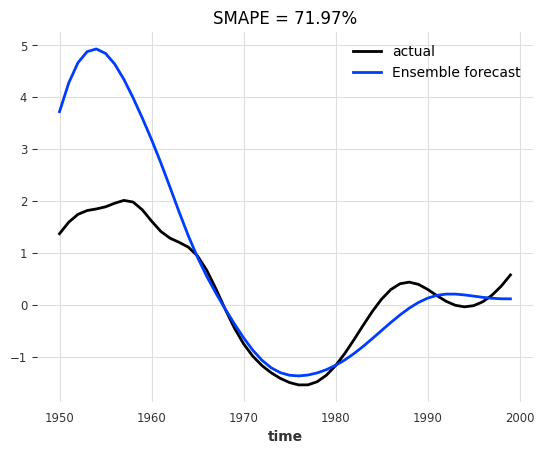

In [ ]:
# call the ensemble eval function with all 5 forecasters:

# column headers and model selection:
col_heads = ["ARIMA",  "Exponential Smoothing", "avg", "Ensemble"]
models2 = models_

# run the ensemble forecast
print("Ensemble of all 2 forecasters:")
res_ensemble = ensemble_eval(train,test, models2)


100%|██████████| 52/52 [10:27<00:00, 12.07s/it]


SMAPE = 105.77


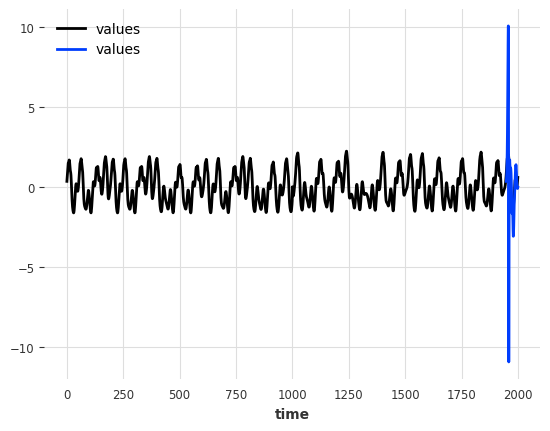

In [ ]:
#from darts.models import RegressionEnsembleModel

#models = [FFT(nr_freqs_to_keep=0,trend='poly',trend_poly_degree=0),
#        #ARIMA(p = 3, d= 1, q=5,random_state=0),
#        AutoARIMA(),]

ensemble_model = RegressionEnsembleModel(
    forecasting_models=models_, regression_train_n_points=12
)

backtest = ensemble_model.historical_forecasts(
    all, start=0.9725, forecast_horizon=5, verbose=True
)
print("SMAPE = %.2f" % (smape(backtest, all)))
all.plot()
backtest.plot()



SMAPE = 105.77


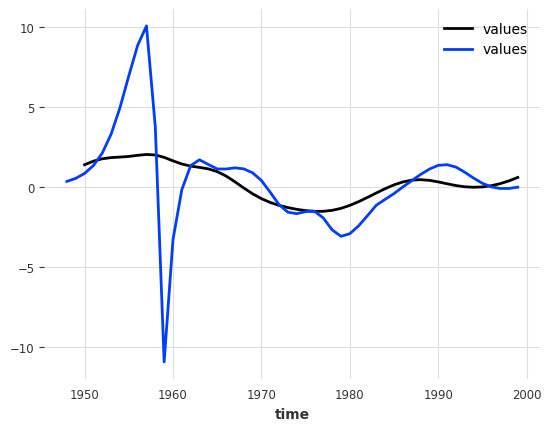

In [ ]:
print("SMAPE = %.2f" % (smape(backtest, all)))
test.plot()
backtest.plot()

In [ ]:
len(backtest)

52

#### FFT & StatsForecastAutoARIMA


In [ ]:
models_=[
        StatsForecastAutoARIMA(),
        FFT(nr_freqs_to_keep=0,trend='poly',trend_poly_degree=0)
        #ARIMA(p = 3, d= 1, q=5,random_state=0),
        #ExponentialSmoothing(trend=None, damped=False, seasonal=None, random_state=0),
        #RandomForest(lags= 12, output_chunk_length= 25, n_estimators= 50, random_state= 0),
        #NBEATSModel(input_chunk_length=5,output_chunk_length=5,random_state=0),
        #FourTheta(theta=0,seasonality_period = None, season_mode = SeasonalityMode.ADDITIVE, model_mode = ModelMode.ADDITIVE,trend_mode=TrendMode.EXPONENTIAL, normalization=True)
]

In [ ]:
# ensemble forecast evaluation function:
# the eval function calls the methods contained in the list 'models'

def ensemble_eval(train, test, models):
    #t_start =  time.perf_counter()
    n_train = 12                # use 50 observation to train the ensemble model
    n_val = len(test)            # forecast as many periods as are in the valuation dataset


    # compute predictions
    # ensemble_model = RegressionEnsembleModel(forecasting_models=models, regression_train_n_points=n_train)
    # new Jan 022: RegressionEnsembleModel class no longer accepts as argument the list "models" of previously instantiated models
    # instead, explicitly list each of the forecast methods
    ensemble_model = RegressionEnsembleModel(
                                forecasting_models=[
                                    #Prophet(),
                                    FFT(nr_freqs_to_keep=0,trend='poly',trend_poly_degree=0),
                                    StatsForecastAutoARIMA(),
                                    #ARIMA(p = 3, d= 1, q=5,random_state=0),
                                    #ExponentialSmoothing(trend=None, damped=False, seasonal=None, random_state=0),
                                    #RandomForest(lags= 12, output_chunk_length= 25, n_estimators= 50, random_state= 0),
                                    #NBEATSModel(input_chunk_length=5,output_chunk_length=5,random_state=0),
                                    #FourTheta(theta=0,seasonality_period = None, season_mode = SeasonalityMode.ADDITIVE, model_mode = ModelMode.ADDITIVE,trend_mode=TrendMode.EXPONENTIAL, normalization=True)
                                                        ],
                                regression_train_n_points=12,
                                #regression_model = RandomForest(lags=None,lags_future_covariates = [0], lags_past_covariates = None, output_chunk_length=12 ,add_encoders=None, n_estimators= 50, random_state= 0 )
                                )


    ensemble_model.fit(train)
    forecast = ensemble_model.predict(n_val)
    resid = forecast - test


    res_accuracy = accuracy_metrics(test, forecast, resid)#,t_start


    # plot the ensemble forecast
    #data.plot(label="actual") #kalau mau liat seluruh data
    test.plot(label="actual") # kalau mau liat perbandingan data test dgn forecast
    forecast.plot(label="Ensemble forecast")
    plt.title("SMAPE = {:.2f}%".format(res_accuracy["SMAPE"]))
    plt.legend();


    results = [forecast, res_accuracy]
    return results

Ensemble of all 2 forecasters:


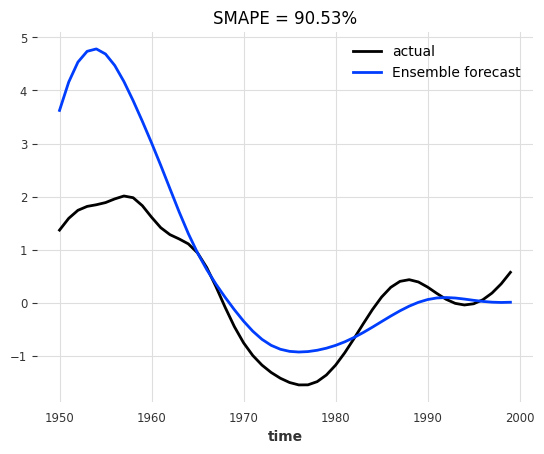

In [ ]:
# call the ensemble eval function with all 5 forecasters:

# column headers and model selection:
col_heads = ["ARIMA",  "Exponential Smoothing", "avg", "Ensemble"]
models2 = models_

# run the ensemble forecast
print("Ensemble of all 2 forecasters:")
res_ensemble = ensemble_eval(train,test, models2)


100%|██████████| 52/52 [07:22<00:00,  8.52s/it]


SMAPE = 108.77


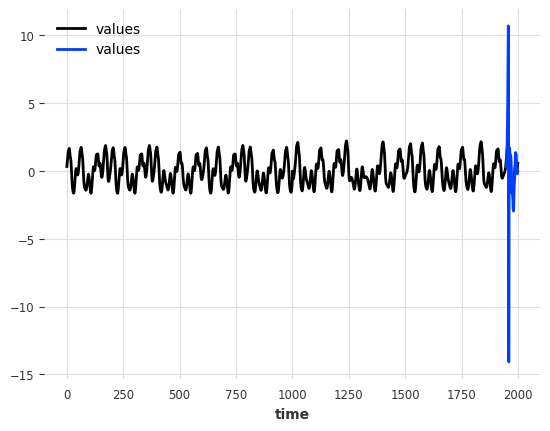

In [ ]:
#from darts.models import RegressionEnsembleModel

#models = [FFT(nr_freqs_to_keep=0,trend='poly',trend_poly_degree=0),
#        #ARIMA(p = 3, d= 1, q=5,random_state=0),
#        AutoARIMA(),]

ensemble_model = RegressionEnsembleModel(
    forecasting_models=models_, regression_train_n_points=12
)

backtest = ensemble_model.historical_forecasts(
    all, start=0.9725, forecast_horizon=5, verbose=True
)
print("SMAPE = %.2f" % (smape(backtest, all)))
all.plot()
backtest.plot()



SMAPE = 108.77


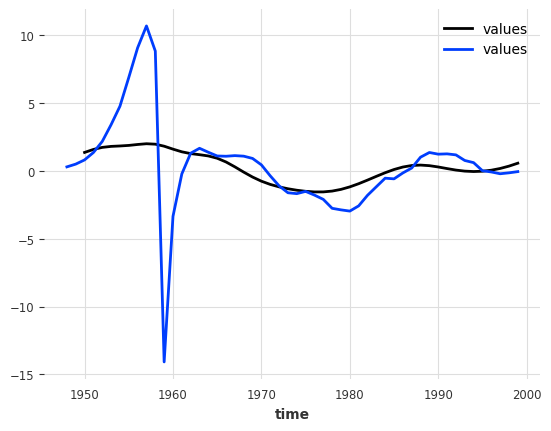

In [ ]:
print("SMAPE = %.2f" % (smape(backtest, all)))
test.plot()
backtest.plot()

#### AutoARIMA & Croston

In [ ]:
from darts.models import Croston

In [ ]:
models_=[
        AutoARIMA(),
        Croston(version='optimized',alpha_d=0.0,alpha_p=0.0),
        #ARIMA(p = 3, d=0, q=5,random_state=0),
        #ExponentialSmoothing(trend=None, damped=False, seasonal=None, random_state=0),
        #RandomForest(lags= 12, output_chunk_length= 25, n_estimators= 50, random_state= 0),
        #NBEATSModel(input_chunk_length=5,output_chunk_length=5,random_state=0),
        #FourTheta(theta=0,seasonality_period = None, season_mode = SeasonalityMode.ADDITIVE, model_mode = ModelMode.ADDITIVE,trend_mode=TrendMode.EXPONENTIAL, normalization=True)
]

In [ ]:
# ensemble forecast evaluation function:
# the eval function calls the methods contained in the list 'models'

def ensemble_eval(train, test, models):
    #t_start =  time.perf_counter()
    n_train = 12                # use 50 observation to train the ensemble model
    n_val = len(test)            # forecast as many periods as are in the valuation dataset


    # compute predictions
    # ensemble_model = RegressionEnsembleModel(forecasting_models=models, regression_train_n_points=n_train)
    # new Jan 022: RegressionEnsembleModel class no longer accepts as argument the list "models" of previously instantiated models
    # instead, explicitly list each of the forecast methods
    ensemble_model = RegressionEnsembleModel(
                                forecasting_models=[
                                    AutoARIMA(),
                                    Croston(version='optimized',alpha_d=0.0,alpha_p=0.0),
                                    #ARIMA(p = 3, d= 0, q=5,random_state=0),
                                    #ExponentialSmoothing(trend=None, damped=False, seasonal=None, random_state=0),
                                    #RandomForest(lags= 12, output_chunk_length= 25, n_estimators= 50, random_state= 0),
                                    #NBEATSModel(input_chunk_length=5,output_chunk_length=5,random_state=0),
                                    #FourTheta(theta=0,seasonality_period = None, season_mode = SeasonalityMode.ADDITIVE, model_mode = ModelMode.ADDITIVE,trend_mode=TrendMode.EXPONENTIAL, normalization=True)
                                                        ],
                                regression_train_n_points=12,
                                #regression_model = RandomForest(lags=None,lags_future_covariates = [0], lags_past_covariates = None, output_chunk_length=12 ,add_encoders=None, n_estimators= 50, random_state= 0 )
                                )
    backtest = ensemble_model.historical_forecasts(all, start=0.9, forecast_horizon=10, verbose=True)

    ensemble_model.fit(train)
    forecast = ensemble_model.predict(n_val)
    resid = forecast - test


    res_accuracy = accuracy_metrics(test, forecast, resid)#,t_start


    # plot the ensemble forecast
    #data.plot(label="actual") #kalau mau liat seluruh data
    test.plot(label="actual") # kalau mau liat perbandingan data test dgn forecast
    forecast.plot(label="Ensemble forecast")
    plt.title("SMAPE = {:.2f}%".format(res_accuracy["SMAPE"]))
    plt.legend();


    results = [forecast, res_accuracy]
    return results


In [132]:
# call the ensemble eval function with all 5 forecasters:

# column headers and model selection:
col_heads = ["ARIMA",  "Exponential Smoothing", "avg", "Ensemble"]
models2 = models_

# run the ensemble forecast
print("Ensemble of all 2 forecasters:")
res_ensemble = ensemble_eval(train,test, models2)


Ensemble of all 2 forecasters:


 92%|█████████▏| 176/192 [8:14:49<44:59, 168.69s/it]
ERROR:root:Internal Python error in the inspect module.
Below is the traceback from this internal error.



Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/IPython/core/interactiveshell.py", line 3553, in run_code
    exec(code_obj, self.user_global_ns, self.user_ns)
  File "<ipython-input-132-c09b783d8ce0>", line 9, in <cell line: 9>
    res_ensemble = ensemble_eval(train,test, models2)
  File "<ipython-input-131-1513ffe5e9d0>", line 27, in ensemble_eval
    backtest = ensemble_model.historical_forecasts(all, start=0.9, forecast_horizon=10, verbose=True)
  File "/usr/local/lib/python3.10/dist-packages/darts/utils/utils.py", line 179, in sanitized_method
    return method_to_sanitize(self, *only_args.values(), **only_kwargs)
  File "/usr/local/lib/python3.10/dist-packages/darts/models/forecasting/forecasting_model.py", line 1050, in historical_forecasts
    model._fit_wrapper(
  File "/usr/local/lib/python3.10/dist-packages/darts/models/forecasting/forecasting_model.py", line 2164, in _fit_wrapper
    self.fit(
  File "/usr/local/lib/python3.10/dist-package

TypeError: ignored

In [ ]:
#from darts.models import RegressionEnsembleModel

#models = [FFT(nr_freqs_to_keep=0,trend='poly',trend_poly_degree=0),
#        #ARIMA(p = 3, d= 1, q=5,random_state=0),
#        AutoARIMA(),]

ensemble_model = RegressionEnsembleModel(
    forecasting_models=models_, regression_train_n_points=12
)

backtest = ensemble_model.historical_forecasts(
    all, start=0.9725, forecast_horizon=5, verbose=True
)
print("SMAPE = %.2f" % (smape(backtest, all)))
all.plot()
backtest.plot()



In [ ]:
print("SMAPE = %.2f" % (smape(backtest, all)))
test.plot()
backtest.plot()

#### ARIMA & Expon

In [ ]:
from darts.models import NaiveDrift,FFT

In [ ]:
models_=[
        #StatsForecastAutoARIMA(),
        #FFT(nr_freqs_to_keep=0,trend='poly',trend_poly_degree=0),
        #NaiveDrift()
        ARIMA(p = 3, d= 0, q=5,random_state=0),
        ExponentialSmoothing(trend=None, damped=False, seasonal=None, random_state=0),
        #RandomForest(lags= 12, output_chunk_length= 25, n_estimators= 50, random_state= 0),
        #NBEATSModel(input_chunk_length=5,output_chunk_length=5,random_state=0),
        #FourTheta(theta=1,seasonality_period = None, season_mode = SeasonalityMode.ADDITIVE, model_mode = ModelMode.ADDITIVE,trend_mode=TrendMode.EXPONENTIAL, normalization=True)
]

In [ ]:
# ensemble forecast evaluation function:
# the eval function calls the methods contained in the list 'models'

def ensemble_eval(train, test, models):
    #t_start =  time.perf_counter()
    n_train = 12                # use 50 observation to train the ensemble model
    n_val = len(test)            # forecast as many periods as are in the valuation dataset


    # compute predictions
    # ensemble_model = RegressionEnsembleModel(forecasting_models=models, regression_train_n_points=n_train)
    # new Jan 022: RegressionEnsembleModel class no longer accepts as argument the list "models" of previously instantiated models
    # instead, explicitly list each of the forecast methods
    ensemble_model = RegressionEnsembleModel(
                                forecasting_models=[
                                    #Prophet(),
                                    #FFT(nr_freqs_to_keep=0,trend='poly',trend_poly_degree=0),
                                    #NaiveDrift()
                                    #StatsForecastAutoARIMA(),
                                    ARIMA(p = 3, d=0, q=5,random_state=0),
                                    ExponentialSmoothing(trend=None, damped=False, seasonal=None, random_state=0),
                                    #RandomForest(lags= 12, output_chunk_length= 25, n_estimators= 50, random_state= 0),
                                    #NBEATSModel(input_chunk_length=5,output_chunk_length=5,random_state=0),
                                    #FourTheta(theta=1,seasonality_period = None, season_mode = SeasonalityMode.ADDITIVE, model_mode = ModelMode.ADDITIVE,trend_mode=TrendMode.EXPONENTIAL, normalization=True)
                                                        ],
                                regression_train_n_points=12,
                                #regression_model = RandomForest(lags=None,lags_future_covariates = [0], lags_past_covariates = None, output_chunk_length=12 ,add_encoders=None, n_estimators= 50, random_state= 0 )
                                )


    ensemble_model.fit(train)
    forecast = ensemble_model.predict(n_val)
    resid = forecast - test


    res_accuracy = accuracy_metrics(test, forecast, resid)#,t_start


    # plot the ensemble forecast
    #data.plot(label="actual") #kalau mau liat seluruh data
    test.plot(label="actual") # kalau mau liat perbandingan data test dgn forecast
    forecast.plot(label="Ensemble forecast")
    plt.title("SMAPE = {:.2f}%".format(res_accuracy["SMAPE"]))
    plt.legend();


    results = [forecast, res_accuracy]
    return results

In [ ]:
# call the ensemble eval function with all 5 forecasters:

# column headers and model selection:
col_heads = ["ARIMA",  "Exponential Smoothing", "avg", "Ensemble"]
models2 = models_

# run the ensemble forecast
print("Ensemble of all 2 forecasters:")
res_ensemble = ensemble_eval(train,test, models2)


In [ ]:
#from darts.models import RegressionEnsembleModel

#models = [FFT(nr_freqs_to_keep=0,trend='poly',trend_poly_degree=0),
#        #ARIMA(p = 3, d= 1, q=5,random_state=0),
#        AutoARIMA(),]

ensemble_model = RegressionEnsembleModel(
    forecasting_models=models_, regression_train_n_points=12
)

backtest = ensemble_model.historical_forecasts(
    all, start=0.9725, forecast_horizon=5, verbose=True
)
print("SMAPE = %.2f" % (smape(backtest, all)))
all.plot()
backtest.plot()



In [ ]:
print("SMAPE = %.2f" % (smape(backtest, all)))
test.plot()
backtest.plot()

#### FFT & AutoARIMA

In [ ]:
models_=[
        #StatsForecastAutoARIMA(),
        FFT(nr_freqs_to_keep=0,trend='poly',trend_poly_degree=0),
        #ARIMA(p = 3, d= 1, q=5,random_state=0),
        AutoARIMA(),
        #ExponentialSmoothing(trend=None, damped=False, seasonal=None, random_state=0),
        #RandomForest(lags= 12, output_chunk_length= 25, n_estimators= 50, random_state= 0),
        #NBEATSModel(input_chunk_length=5,output_chunk_length=5,random_state=0),
        #FourTheta(theta=0,seasonality_period = None, season_mode = SeasonalityMode.ADDITIVE, model_mode = ModelMode.ADDITIVE,trend_mode=TrendMode.EXPONENTIAL, normalization=True)
]

In [ ]:
from darts.models import RegressionEnsembleModel

models = [FFT(nr_freqs_to_keep=0,trend='poly',trend_poly_degree=0),
        #ARIMA(p = 3, d= 1, q=5,random_state=0),
        AutoARIMA(),]

ensemble_model = RegressionEnsembleModel(
    forecasting_models=models, regression_train_n_points=12
)

backtest = ensemble_model.historical_forecasts(
    all, start=0.9, forecast_horizon=3, verbose=True
)

print("SMAPE = %.2f" % (smape(backtest, all)))
all.plot()
backtest.plot()


In [ ]:
# ensemble forecast evaluation function:
# the eval function calls the methods contained in the list 'models'

def ensemble_eval(train, test, models):
    #t_start =  time.perf_counter()
    n_train = 12                # use 50 observation to train the ensemble model
    n_val = len(test)            # forecast as many periods as are in the valuation dataset


    # compute predictions
    # ensemble_model = RegressionEnsembleModel(forecasting_models=models, regression_train_n_points=n_train)
    # new Jan 022: RegressionEnsembleModel class no longer accepts as argument the list "models" of previously instantiated models
    # instead, explicitly list each of the forecast methods
    ensemble_model = RegressionEnsembleModel(
                                forecasting_models=[
                                    #Prophet(),
                                    FFT(nr_freqs_to_keep=0,trend='poly',trend_poly_degree=0),
                                    #StatsForecastAutoARIMA(),
                                    AutoARIMA(),
                                    #ARIMA(p = 3, d= 1, q=5,random_state=0),
                                    #ExponentialSmoothing(trend=None, damped=False, seasonal=None, random_state=0),
                                    #RandomForest(lags= 12, output_chunk_length= 25, n_estimators= 50, random_state= 0),
                                    #NBEATSModel(input_chunk_length=5,output_chunk_length=5,random_state=0),
                                    #FourTheta(theta=0,seasonality_period = None, season_mode = SeasonalityMode.ADDITIVE, model_mode = ModelMode.ADDITIVE,trend_mode=TrendMode.EXPONENTIAL, normalization=True)
                                                        ],
                                regression_train_n_points=12,
                                #regression_model = RandomForest(lags=None,lags_future_covariates = [0], lags_past_covariates = None, output_chunk_length=12 ,add_encoders=None, n_estimators= 50, random_state= 0 )
                                )

    backtest = ensemble_model.historical_forecasts(all, start=0.6, forecast_horizon=3, verbose=True)


    ensemble_model.fit(train)
    forecast = ensemble_model.predict(n_val)
    resid = forecast - test


    res_accuracy = accuracy_metrics(test, forecast, resid)#,t_start
    back_accuracy = smape(backtest, all)

    # plot the ensemble forecast
    #data.plot(label="actual") #kalau mau liat seluruh data
    test.plot(label="actual") # kalau mau liat perbandingan data test dgn forecast
    forecast.plot(label="Ensemble forecast")
    plt.title("SMAPE = {:.2f}%".format(res_accuracy["SMAPE"]))
    plt.legend();


    results = [forecast, res_accuracy,back_accuracy]
    return results


In [ ]:
# call the ensemble eval function with all 5 forecasters:

# column headers and model selection:
col_heads = ["ARIMA",  "Exponential Smoothing", "avg", "Ensemble"]
models2 = models_

# run the ensemble forecast
print("Ensemble of all 2 forecasters:")
res_ensemble = ensemble_eval(train,test, models2)


Ensemble of all 2 forecasters:


 11%|█▏        | 91/799 [2:57:39<23:23:28, 118.94s/it]

#### FFT & NaiveDrift

In [ ]:
from darts.models import NaiveDrift,FFT

In [ ]:
models_=[
        #StatsForecastAutoARIMA(),
        FFT(nr_freqs_to_keep=0,trend='poly',trend_poly_degree=0),
        NaiveDrift()
        #ARIMA(p = 3, d= 1, q=5,random_state=0),
        #ExponentialSmoothing(trend=None, damped=False, seasonal=None, random_state=0),
        #RandomForest(lags= 12, output_chunk_length= 25, n_estimators= 50, random_state= 0),
        #NBEATSModel(input_chunk_length=5,output_chunk_length=5,random_state=0),
        #FourTheta(theta=1,seasonality_period = None, season_mode = SeasonalityMode.ADDITIVE, model_mode = ModelMode.ADDITIVE,trend_mode=TrendMode.EXPONENTIAL, normalization=True)
]

In [ ]:
# ensemble forecast evaluation function:
# the eval function calls the methods contained in the list 'models'

def ensemble_eval(train, test, models):
    #t_start =  time.perf_counter()
    n_train = 12                # use 50 observation to train the ensemble model
    n_val = len(test)            # forecast as many periods as are in the valuation dataset


    # compute predictions
    # ensemble_model = RegressionEnsembleModel(forecasting_models=models, regression_train_n_points=n_train)
    # new Jan 022: RegressionEnsembleModel class no longer accepts as argument the list "models" of previously instantiated models
    # instead, explicitly list each of the forecast methods
    ensemble_model = RegressionEnsembleModel(
                                forecasting_models=[
                                    #Prophet(),
                                    FFT(nr_freqs_to_keep=0,trend='poly',trend_poly_degree=0),
                                    NaiveDrift()
                                    #StatsForecastAutoARIMA(),
                                    #ARIMA(p = 3, d= 1, q=5,random_state=0),
                                    #ExponentialSmoothing(trend=None, damped=False, seasonal=None, random_state=0),
                                    #RandomForest(lags= 12, output_chunk_length= 25, n_estimators= 50, random_state= 0),
                                    #NBEATSModel(input_chunk_length=5,output_chunk_length=5,random_state=0),
                                    #FourTheta(theta=1,seasonality_period = None, season_mode = SeasonalityMode.ADDITIVE, model_mode = ModelMode.ADDITIVE,trend_mode=TrendMode.EXPONENTIAL, normalization=True)
                                                        ],
                                regression_train_n_points=12,
                                #regression_model = RandomForest(lags=None,lags_future_covariates = [0], lags_past_covariates = None, output_chunk_length=12 ,add_encoders=None, n_estimators= 50, random_state= 0 )
                                )


    ensemble_model.fit(train)
    forecast = ensemble_model.predict(n_val)
    resid = forecast - test


    res_accuracy = accuracy_metrics(test, forecast, resid)#,t_start


    # plot the ensemble forecast
    #data.plot(label="actual") #kalau mau liat seluruh data
    test.plot(label="actual") # kalau mau liat perbandingan data test dgn forecast
    forecast.plot(label="Ensemble forecast")
    plt.title("SMAPE = {:.2f}%".format(res_accuracy["SMAPE"]))
    plt.legend();


    results = [forecast, res_accuracy]
    return results


In [ ]:
# call the ensemble eval function with all 5 forecasters:

# column headers and model selection:
col_heads = ["ARIMA",  "Exponential Smoothing", "avg", "Ensemble"]
models2 = models_

# run the ensemble forecast
print("Ensemble of all 2 forecasters:")
res_ensemble = ensemble_eval(train,test, models2)


#### FFT & Expon

In [ ]:
from darts.models import NaiveDrift,FFT

In [ ]:
models_=[
        #StatsForecastAutoARIMA(),
        FFT(nr_freqs_to_keep=0,trend='poly',trend_poly_degree=0),
        #NaiveDrift()
        #ARIMA(p = 3, d= 1, q=5,random_state=0),
        ExponentialSmoothing(trend=None, damped=False, seasonal=None, random_state=0),
        #RandomForest(lags= 12, output_chunk_length= 25, n_estimators= 50, random_state= 0),
        #NBEATSModel(input_chunk_length=5,output_chunk_length=5,random_state=0),
        #FourTheta(theta=1,seasonality_period = None, season_mode = SeasonalityMode.ADDITIVE, model_mode = ModelMode.ADDITIVE,trend_mode=TrendMode.EXPONENTIAL, normalization=True)
]

In [ ]:
# ensemble forecast evaluation function:
# the eval function calls the methods contained in the list 'models'

def ensemble_eval(train, test, models):
    #t_start =  time.perf_counter()
    n_train = 12                # use 50 observation to train the ensemble model
    n_val = len(test)            # forecast as many periods as are in the valuation dataset


    # compute predictions
    # ensemble_model = RegressionEnsembleModel(forecasting_models=models, regression_train_n_points=n_train)
    # new Jan 022: RegressionEnsembleModel class no longer accepts as argument the list "models" of previously instantiated models
    # instead, explicitly list each of the forecast methods
    ensemble_model = RegressionEnsembleModel(
                                forecasting_models=[
                                    #Prophet(),
                                    FFT(nr_freqs_to_keep=0,trend='poly',trend_poly_degree=0),
                                    #NaiveDrift()
                                    #StatsForecastAutoARIMA(),
                                    #ARIMA(p = 3, d= 1, q=5,random_state=0),
                                    ExponentialSmoothing(trend=None, damped=False, seasonal=None, random_state=0),
                                    #RandomForest(lags= 12, output_chunk_length= 25, n_estimators= 50, random_state= 0),
                                    #NBEATSModel(input_chunk_length=5,output_chunk_length=5,random_state=0),
                                    #FourTheta(theta=1,seasonality_period = None, season_mode = SeasonalityMode.ADDITIVE, model_mode = ModelMode.ADDITIVE,trend_mode=TrendMode.EXPONENTIAL, normalization=True)
                                                        ],
                                regression_train_n_points=12,
                                #regression_model = RandomForest(lags=None,lags_future_covariates = [0], lags_past_covariates = None, output_chunk_length=12 ,add_encoders=None, n_estimators= 50, random_state= 0 )
                                )


    ensemble_model.fit(train)
    forecast = ensemble_model.predict(n_val)
    resid = forecast - test


    res_accuracy = accuracy_metrics(test, forecast, resid)#,t_start


    # plot the ensemble forecast
    #data.plot(label="actual") #kalau mau liat seluruh data
    test.plot(label="actual") # kalau mau liat perbandingan data test dgn forecast
    forecast.plot(label="Ensemble forecast")
    plt.title("SMAPE = {:.2f}%".format(res_accuracy["SMAPE"]))
    plt.legend();


    results = [forecast, res_accuracy]
    return results


In [ ]:
# call the ensemble eval function with all 5 forecasters:

# column headers and model selection:
col_heads = ["ARIMA",  "Exponential Smoothing", "avg", "Ensemble"]
models2 = models_

# run the ensemble forecast
print("Ensemble of all 2 forecasters:")
res_ensemble = ensemble_eval(train,test, models2)


#### FFT & Croston

In [ ]:
from darts.models import NaiveDrift,FFT,Croston

In [ ]:
models_=[
        #StatsForecastAutoARIMA(),
        FFT(nr_freqs_to_keep=0,trend='poly',trend_poly_degree=0),
        #NaiveDrift()
        Croston(version='optimized',alpha_d=0.0,alpha_p=0.0),#(version='tsb',alpha_d=0.01,alpha_p=0.0),
        #ARIMA(p = 3, d= 1, q=5,random_state=0),
        #ExponentialSmoothing(trend=None, damped=False, seasonal=None, random_state=0),
        #RandomForest(lags= 12, output_chunk_length= 25, n_estimators= 50, random_state= 0),
        #NBEATSModel(input_chunk_length=5,output_chunk_length=5,random_state=0),
        #FourTheta(theta=1,seasonality_period = None, season_mode = SeasonalityMode.ADDITIVE, model_mode = ModelMode.ADDITIVE,trend_mode=TrendMode.EXPONENTIAL, normalization=True)
]

In [ ]:
# ensemble forecast evaluation function:
# the eval function calls the methods contained in the list 'models'

def ensemble_eval(train, test, models):
    #t_start =  time.perf_counter()
    n_train = 12                # use 50 observation to train the ensemble model
    n_val = len(test)            # forecast as many periods as are in the valuation dataset


    # compute predictions
    # ensemble_model = RegressionEnsembleModel(forecasting_models=models, regression_train_n_points=n_train)
    # new Jan 022: RegressionEnsembleModel class no longer accepts as argument the list "models" of previously instantiated models
    # instead, explicitly list each of the forecast methods
    ensemble_model = RegressionEnsembleModel(
                                forecasting_models=[
                                    #Prophet(),
                                    FFT(nr_freqs_to_keep=0,trend='poly',trend_poly_degree=0),
                                    #NaiveDrift(),
                                    Croston(version='optimized',alpha_d=0.0,alpha_p=0.0),#(version='tsb',alpha_d=0.01,alpha_p=0.0),
                                    #StatsForecastAutoARIMA(),
                                    #ARIMA(p = 3, d= 1, q=5,random_state=0),
                                    #ExponentialSmoothing(trend=None, damped=False, seasonal=None, random_state=0),
                                    #RandomForest(lags= 12, output_chunk_length= 25, n_estimators= 50, random_state= 0),
                                    #NBEATSModel(input_chunk_length=5,output_chunk_length=5,random_state=0),
                                    #FourTheta(theta=1,seasonality_period = None, season_mode = SeasonalityMode.ADDITIVE, model_mode = ModelMode.ADDITIVE,trend_mode=TrendMode.EXPONENTIAL, normalization=True)
                                                        ],
                                regression_train_n_points=12,
                                #regression_model = RandomForest(lags=None,lags_future_covariates = [0], lags_past_covariates = None, output_chunk_length=12 ,add_encoders=None, n_estimators= 50, random_state= 0 )
                                )


    ensemble_model.fit(train)
    forecast = ensemble_model.predict(n_val)
    resid = forecast - test


    res_accuracy = accuracy_metrics(test, forecast, resid)#,t_start


    # plot the ensemble forecast
    #data.plot(label="actual") #kalau mau liat seluruh data
    test.plot(label="actual") # kalau mau liat perbandingan data test dgn forecast
    forecast.plot(label="Ensemble forecast")
    plt.title("SMAPE = {:.2f}%".format(res_accuracy["SMAPE"]))
    plt.legend();


    results = [forecast, res_accuracy]
    return results


In [ ]:
# call the ensemble eval function with all 5 forecasters:

# column headers and model selection:
col_heads = ["ARIMA",  "Exponential Smoothing", "avg", "Ensemble"]
models2 = models_

# run the ensemble forecast
print("Ensemble of all 2 forecasters:")
res_ensemble = ensemble_eval(train,test, models2)


#### FFT & SF AutoTheta

In [ ]:
from darts.models import NaiveDrift,FFT,Croston,StatsForecastAutoTheta

In [ ]:
models_=[
        #StatsForecastAutoARIMA(),
        FFT(nr_freqs_to_keep=0,trend='poly',trend_poly_degree=0),
        #NaiveDrift()
        StatsForecastAutoTheta(),
        #Croston(version='tsb',alpha_d=0.01,alpha_p=0.0),
        #ARIMA(p = 3, d= 1, q=5,random_state=0),
        #ExponentialSmoothing(trend=None, damped=False, seasonal=None, random_state=0),
        #RandomForest(lags= 12, output_chunk_length= 25, n_estimators= 50, random_state= 0),
        #NBEATSModel(input_chunk_length=5,output_chunk_length=5,random_state=0),
        #FourTheta(theta=1,seasonality_period = None, season_mode = SeasonalityMode.ADDITIVE, model_mode = ModelMode.ADDITIVE,trend_mode=TrendMode.EXPONENTIAL, normalization=True)
]

In [ ]:
# ensemble forecast evaluation function:
# the eval function calls the methods contained in the list 'models'

def ensemble_eval(train, test, models):
    #t_start =  time.perf_counter()
    n_train = 12                # use 50 observation to train the ensemble model
    n_val = len(test)            # forecast as many periods as are in the valuation dataset


    # compute predictions
    # ensemble_model = RegressionEnsembleModel(forecasting_models=models, regression_train_n_points=n_train)
    # new Jan 022: RegressionEnsembleModel class no longer accepts as argument the list "models" of previously instantiated models
    # instead, explicitly list each of the forecast methods
    ensemble_model = RegressionEnsembleModel(
                                forecasting_models=[
                                    #Prophet(),
                                    FFT(nr_freqs_to_keep=0,trend='poly',trend_poly_degree=0),
                                    StatsForecastAutoTheta()
                                    #NaiveDrift(),
                                    #Croston(version='tsb',alpha_d=0.01,alpha_p=0.0),
                                    #StatsForecastAutoARIMA(),
                                    #ARIMA(p = 3, d= 1, q=5,random_state=0),
                                    #ExponentialSmoothing(trend=None, damped=False, seasonal=None, random_state=0),
                                    #RandomForest(lags= 12, output_chunk_length= 25, n_estimators= 50, random_state= 0),
                                    #NBEATSModel(input_chunk_length=5,output_chunk_length=5,random_state=0),
                                    #FourTheta(theta=1,seasonality_period = None, season_mode = SeasonalityMode.ADDITIVE, model_mode = ModelMode.ADDITIVE,trend_mode=TrendMode.EXPONENTIAL, normalization=True)
                                                        ],
                                regression_train_n_points=12,
                                #regression_model = RandomForest(lags=None,lags_future_covariates = [0], lags_past_covariates = None, output_chunk_length=12 ,add_encoders=None, n_estimators= 50, random_state= 0 )
                                )


    ensemble_model.fit(train)
    forecast = ensemble_model.predict(n_val)
    resid = forecast - test


    res_accuracy = accuracy_metrics(test, forecast, resid)#,t_start


    # plot the ensemble forecast
    #data.plot(label="actual") #kalau mau liat seluruh data
    test.plot(label="actual") # kalau mau liat perbandingan data test dgn forecast
    forecast.plot(label="Ensemble forecast")
    plt.title("SMAPE = {:.2f}%".format(res_accuracy["SMAPE"]))
    plt.legend();


    results = [forecast, res_accuracy]
    return results


In [ ]:
# call the ensemble eval function with all 5 forecasters:

# column headers and model selection:
col_heads = ["ARIMA",  "Exponential Smoothing", "avg", "Ensemble"]
models2 = models_

# run the ensemble forecast
print("Ensemble of all 2 forecasters:")
res_ensemble = ensemble_eval(train,test, models2)


#### FFT & SF AutoETS

In [ ]:
from darts.models import NaiveDrift,FFT,Croston,StatsForecastAutoETS

In [ ]:
models_=[
        #StatsForecastAutoARIMA(),
        FFT(nr_freqs_to_keep=0,trend='poly',trend_poly_degree=0),
        #NaiveDrift()
        StatsForecastAutoETS(season_length=2,model='ANN'),
        #StatsForecastAutoTheta(),
        #Croston(version='tsb',alpha_d=0.01,alpha_p=0.0),
        #ARIMA(p = 3, d= 1, q=5,random_state=0),
        #ExponentialSmoothing(trend=None, damped=False, seasonal=None, random_state=0),
        #RandomForest(lags= 12, output_chunk_length= 25, n_estimators= 50, random_state= 0),
        #NBEATSModel(input_chunk_length=5,output_chunk_length=5,random_state=0),
        #FourTheta(theta=1,seasonality_period = None, season_mode = SeasonalityMode.ADDITIVE, model_mode = ModelMode.ADDITIVE,trend_mode=TrendMode.EXPONENTIAL, normalization=True)
]

In [ ]:
# ensemble forecast evaluation function:
# the eval function calls the methods contained in the list 'models'

def ensemble_eval(train, test, models):
    #t_start =  time.perf_counter()
    n_train = 12                # use 50 observation to train the ensemble model
    n_val = len(test)            # forecast as many periods as are in the valuation dataset


    # compute predictions
    # ensemble_model = RegressionEnsembleModel(forecasting_models=models, regression_train_n_points=n_train)
    # new Jan 022: RegressionEnsembleModel class no longer accepts as argument the list "models" of previously instantiated models
    # instead, explicitly list each of the forecast methods
    ensemble_model = RegressionEnsembleModel(
                                forecasting_models=[
                                    #Prophet(),
                                    FFT(nr_freqs_to_keep=0,trend='poly',trend_poly_degree=0),
                                    StatsForecastAutoETS(season_length=2,model='ANN'),
                                    #StatsForecastAutoTheta()
                                    #NaiveDrift(),
                                    #Croston(version='tsb',alpha_d=0.01,alpha_p=0.0),
                                    #StatsForecastAutoARIMA(),
                                    #ARIMA(p = 3, d= 1, q=5,random_state=0),
                                    #ExponentialSmoothing(trend=None, damped=False, seasonal=None, random_state=0),
                                    #RandomForest(lags= 12, output_chunk_length= 25, n_estimators= 50, random_state= 0),
                                    #NBEATSModel(input_chunk_length=5,output_chunk_length=5,random_state=0),
                                    #FourTheta(theta=1,seasonality_period = None, season_mode = SeasonalityMode.ADDITIVE, model_mode = ModelMode.ADDITIVE,trend_mode=TrendMode.EXPONENTIAL, normalization=True)
                                                        ],
                                regression_train_n_points=12,
                                #regression_model = RandomForest(lags=None,lags_future_covariates = [0], lags_past_covariates = None, output_chunk_length=12 ,add_encoders=None, n_estimators= 50, random_state= 0 )
                                )


    ensemble_model.fit(train)
    forecast = ensemble_model.predict(n_val)
    resid = forecast - test


    res_accuracy = accuracy_metrics(test, forecast, resid)#,t_start


    # plot the ensemble forecast
    #data.plot(label="actual") #kalau mau liat seluruh data
    test.plot(label="actual") # kalau mau liat perbandingan data test dgn forecast
    forecast.plot(label="Ensemble forecast")
    plt.title("SMAPE = {:.2f}%".format(res_accuracy["SMAPE"]))
    plt.legend();


    results = [forecast, res_accuracy]
    return results


In [ ]:
# call the ensemble eval function with all 5 forecasters:

# column headers and model selection:
col_heads = ["ARIMA",  "Exponential Smoothing", "avg", "Ensemble"]
models2 = models_

# run the ensemble forecast
print("Ensemble of all 2 forecasters:")
res_ensemble = ensemble_eval(train,test, models2)


#### FFT &FourTheta

In [ ]:
models_=[
        #StatsForecastAutoARIMA(),
        FFT(nr_freqs_to_keep=0,trend='poly',trend_poly_degree=0),
        #ARIMA(p = 3, d= 1, q=5,random_state=0),
        #ExponentialSmoothing(trend=None, damped=False, seasonal=None, random_state=0),
        #RandomForest(lags= 12, output_chunk_length= 25, n_estimators= 50, random_state= 0),
        #NBEATSModel(input_chunk_length=5,output_chunk_length=5,random_state=0),
        FourTheta(theta=1,seasonality_period = None, season_mode = SeasonalityMode.ADDITIVE, model_mode = ModelMode.ADDITIVE,trend_mode=TrendMode.EXPONENTIAL, normalization=True)
]

In [ ]:
# ensemble forecast evaluation function:
# the eval function calls the methods contained in the list 'models'

def ensemble_eval(train, test, models):
    #t_start =  time.perf_counter()
    n_train = 12                # use 50 observation to train the ensemble model
    n_val = len(test)            # forecast as many periods as are in the valuation dataset


    # compute predictions
    # ensemble_model = RegressionEnsembleModel(forecasting_models=models, regression_train_n_points=n_train)
    # new Jan 022: RegressionEnsembleModel class no longer accepts as argument the list "models" of previously instantiated models
    # instead, explicitly list each of the forecast methods
    ensemble_model = RegressionEnsembleModel(
                                forecasting_models=[
                                    #Prophet(),
                                    FFT(nr_freqs_to_keep=0,trend='poly',trend_poly_degree=0),
                                    #StatsForecastAutoARIMA(),
                                    #ARIMA(p = 3, d= 1, q=5,random_state=0),
                                    #ExponentialSmoothing(trend=None, damped=False, seasonal=None, random_state=0),
                                    #RandomForest(lags= 12, output_chunk_length= 25, n_estimators= 50, random_state= 0),
                                    #NBEATSModel(input_chunk_length=5,output_chunk_length=5,random_state=0),
                                    FourTheta(theta=1,seasonality_period = None, season_mode = SeasonalityMode.ADDITIVE, model_mode = ModelMode.ADDITIVE,trend_mode=TrendMode.EXPONENTIAL, normalization=True)
                                                        ],
                                regression_train_n_points=12,
                                #regression_model = RandomForest(lags=None,lags_future_covariates = [0], lags_past_covariates = None, output_chunk_length=12 ,add_encoders=None, n_estimators= 50, random_state= 0 )
                                )


    ensemble_model.fit(train)
    forecast = ensemble_model.predict(n_val)
    resid = forecast - test


    res_accuracy = accuracy_metrics(test, forecast, resid)#,t_start


    # plot the ensemble forecast
    #data.plot(label="actual") #kalau mau liat seluruh data
    test.plot(label="actual") # kalau mau liat perbandingan data test dgn forecast
    forecast.plot(label="Ensemble forecast")
    plt.title("SMAPE = {:.2f}%".format(res_accuracy["SMAPE"]))
    plt.legend();


    results = [forecast, res_accuracy]
    return results


In [ ]:
# call the ensemble eval function with all 5 forecasters:

# column headers and model selection:
col_heads = ["ARIMA",  "Exponential Smoothing", "avg", "Ensemble"]
models2 = models_

# run the ensemble forecast
print("Ensemble of all 2 forecasters:")
res_ensemble = ensemble_eval(train,test, models2)


#### AutoARIMA & ARIMA

In [ ]:
models_=[
        AutoARIMA(),
        ARIMA(p = 3, d=0, q=5,random_state=0),
        #ExponentialSmoothing(trend=None, damped=False, seasonal=None, random_state=0),
        #RandomForest(lags= 12, output_chunk_length= 25, n_estimators= 50, random_state= 0),
        #NBEATSModel(input_chunk_length=5,output_chunk_length=5,random_state=0),
        #FourTheta(theta=0,seasonality_period = None, season_mode = SeasonalityMode.ADDITIVE, model_mode = ModelMode.ADDITIVE,trend_mode=TrendMode.EXPONENTIAL, normalization=True)
]

In [ ]:
# ensemble forecast evaluation function:
# the eval function calls the methods contained in the list 'models'

def ensemble_eval(train, test, models):
    #t_start =  time.perf_counter()
    n_train = 12                # use 50 observation to train the ensemble model
    n_val = len(test)            # forecast as many periods as are in the valuation dataset


    # compute predictions
    # ensemble_model = RegressionEnsembleModel(forecasting_models=models, regression_train_n_points=n_train)
    # new Jan 022: RegressionEnsembleModel class no longer accepts as argument the list "models" of previously instantiated models
    # instead, explicitly list each of the forecast methods
    ensemble_model = RegressionEnsembleModel(
                                forecasting_models=[
                                    AutoARIMA(),
                                    ARIMA(p = 3, d= 0, q=5,random_state=0),
                                    #ExponentialSmoothing(trend=None, damped=False, seasonal=None, random_state=0),
                                    #RandomForest(lags= 12, output_chunk_length= 25, n_estimators= 50, random_state= 0),
                                    #NBEATSModel(input_chunk_length=5,output_chunk_length=5,random_state=0),
                                    #FourTheta(theta=0,seasonality_period = None, season_mode = SeasonalityMode.ADDITIVE, model_mode = ModelMode.ADDITIVE,trend_mode=TrendMode.EXPONENTIAL, normalization=True)
                                                        ],
                                regression_train_n_points=12,
                                #regression_model = RandomForest(lags=None,lags_future_covariates = [0], lags_past_covariates = None, output_chunk_length=12 ,add_encoders=None, n_estimators= 50, random_state= 0 )
                                )


    ensemble_model.fit(train)
    forecast = ensemble_model.predict(n_val)
    resid = forecast - test


    res_accuracy = accuracy_metrics(test, forecast, resid)#,t_start


    # plot the ensemble forecast
    #data.plot(label="actual") #kalau mau liat seluruh data
    test.plot(label="actual") # kalau mau liat perbandingan data test dgn forecast
    forecast.plot(label="Ensemble forecast")
    plt.title("SMAPE = {:.2f}%".format(res_accuracy["SMAPE"]))
    plt.legend();


    results = [forecast, res_accuracy]
    return results


In [ ]:
# call the ensemble eval function with all 5 forecasters:

# column headers and model selection:
col_heads = ["ARIMA",  "Exponential Smoothing", "avg", "Ensemble"]
models2 = models_

# run the ensemble forecast
print("Ensemble of all 2 forecasters:")
res_ensemble = ensemble_eval(train,test, models2)


#### AutoARIMA & SF AutoARIMA

In [ ]:
from darts.models import StatsForecastAutoARIMA

In [ ]:
models_=[
        AutoARIMA(),
        StatsForecastAutoARIMA(),
        #ARIMA(p = 3, d=0, q=5,random_state=0),
        #ExponentialSmoothing(trend=None, damped=False, seasonal=None, random_state=0),
        #RandomForest(lags= 12, output_chunk_length= 25, n_estimators= 50, random_state= 0),
        #NBEATSModel(input_chunk_length=5,output_chunk_length=5,random_state=0),
        #FourTheta(theta=0,seasonality_period = None, season_mode = SeasonalityMode.ADDITIVE, model_mode = ModelMode.ADDITIVE,trend_mode=TrendMode.EXPONENTIAL, normalization=True)
]

In [ ]:
# ensemble forecast evaluation function:
# the eval function calls the methods contained in the list 'models'

def ensemble_eval(train, test, models):
    #t_start =  time.perf_counter()
    n_train = 12                # use 50 observation to train the ensemble model
    n_val = len(test)            # forecast as many periods as are in the valuation dataset


    # compute predictions
    # ensemble_model = RegressionEnsembleModel(forecasting_models=models, regression_train_n_points=n_train)
    # new Jan 022: RegressionEnsembleModel class no longer accepts as argument the list "models" of previously instantiated models
    # instead, explicitly list each of the forecast methods
    ensemble_model = RegressionEnsembleModel(
                                forecasting_models=[
                                    AutoARIMA(),
                                    StatsForecastAutoARIMA(),
                                    #ARIMA(p = 3, d= 0, q=5,random_state=0),
                                    #ExponentialSmoothing(trend=None, damped=False, seasonal=None, random_state=0),
                                    #RandomForest(lags= 12, output_chunk_length= 25, n_estimators= 50, random_state= 0),
                                    #NBEATSModel(input_chunk_length=5,output_chunk_length=5,random_state=0),
                                    #FourTheta(theta=0,seasonality_period = None, season_mode = SeasonalityMode.ADDITIVE, model_mode = ModelMode.ADDITIVE,trend_mode=TrendMode.EXPONENTIAL, normalization=True)
                                                        ],
                                regression_train_n_points=12,
                                #regression_model = RandomForest(lags=None,lags_future_covariates = [0], lags_past_covariates = None, output_chunk_length=12 ,add_encoders=None, n_estimators= 50, random_state= 0 )
                                )


    ensemble_model.fit(train)
    forecast = ensemble_model.predict(n_val)
    resid = forecast - test


    res_accuracy = accuracy_metrics(test, forecast, resid)#,t_start


    # plot the ensemble forecast
    #data.plot(label="actual") #kalau mau liat seluruh data
    test.plot(label="actual") # kalau mau liat perbandingan data test dgn forecast
    forecast.plot(label="Ensemble forecast")
    plt.title("SMAPE = {:.2f}%".format(res_accuracy["SMAPE"]))
    plt.legend();


    results = [forecast, res_accuracy]
    return results


In [ ]:
# call the ensemble eval function with all 5 forecasters:

# column headers and model selection:
col_heads = ["ARIMA",  "Exponential Smoothing", "avg", "Ensemble"]
models2 = models_

# run the ensemble forecast
print("Ensemble of all 2 forecasters:")
res_ensemble = ensemble_eval(train,test, models2)


#### AutoARIMA & NaiveDrift

In [ ]:
from darts.models import NaiveDrift

In [ ]:
models_=[
        AutoARIMA(),
        NaiveDrift(),
        #ARIMA(p = 3, d=0, q=5,random_state=0),
        #ExponentialSmoothing(trend=None, damped=False, seasonal=None, random_state=0),
        #RandomForest(lags= 12, output_chunk_length= 25, n_estimators= 50, random_state= 0),
        #NBEATSModel(input_chunk_length=5,output_chunk_length=5,random_state=0),
        #FourTheta(theta=0,seasonality_period = None, season_mode = SeasonalityMode.ADDITIVE, model_mode = ModelMode.ADDITIVE,trend_mode=TrendMode.EXPONENTIAL, normalization=True)
]

In [ ]:
# ensemble forecast evaluation function:
# the eval function calls the methods contained in the list 'models'

def ensemble_eval(train, test, models):
    #t_start =  time.perf_counter()
    n_train = 12                # use 50 observation to train the ensemble model
    n_val = len(test)            # forecast as many periods as are in the valuation dataset


    # compute predictions
    # ensemble_model = RegressionEnsembleModel(forecasting_models=models, regression_train_n_points=n_train)
    # new Jan 022: RegressionEnsembleModel class no longer accepts as argument the list "models" of previously instantiated models
    # instead, explicitly list each of the forecast methods
    ensemble_model = RegressionEnsembleModel(
                                forecasting_models=[
                                    AutoARIMA(),
                                    NaiveDrift(),
                                    #ARIMA(p = 3, d= 0, q=5,random_state=0),
                                    #ExponentialSmoothing(trend=None, damped=False, seasonal=None, random_state=0),
                                    #RandomForest(lags= 12, output_chunk_length= 25, n_estimators= 50, random_state= 0),
                                    #NBEATSModel(input_chunk_length=5,output_chunk_length=5,random_state=0),
                                    #FourTheta(theta=0,seasonality_period = None, season_mode = SeasonalityMode.ADDITIVE, model_mode = ModelMode.ADDITIVE,trend_mode=TrendMode.EXPONENTIAL, normalization=True)
                                                        ],
                                regression_train_n_points=12,
                                #regression_model = RandomForest(lags=None,lags_future_covariates = [0], lags_past_covariates = None, output_chunk_length=12 ,add_encoders=None, n_estimators= 50, random_state= 0 )
                                )


    ensemble_model.fit(train)
    forecast = ensemble_model.predict(n_val)
    resid = forecast - test


    res_accuracy = accuracy_metrics(test, forecast, resid)#,t_start


    # plot the ensemble forecast
    #data.plot(label="actual") #kalau mau liat seluruh data
    test.plot(label="actual") # kalau mau liat perbandingan data test dgn forecast
    forecast.plot(label="Ensemble forecast")
    plt.title("SMAPE = {:.2f}%".format(res_accuracy["SMAPE"]))
    plt.legend();


    results = [forecast, res_accuracy]
    return results


In [ ]:
# call the ensemble eval function with all 5 forecasters:

# column headers and model selection:
col_heads = ["ARIMA",  "Exponential Smoothing", "avg", "Ensemble"]
models2 = models_

# run the ensemble forecast
print("Ensemble of all 2 forecasters:")
res_ensemble = ensemble_eval(train,test, models2)


#### Auto ARIMA & Expon

In [ ]:
models_=[
        AutoARIMA(),
        #ARIMA(p = 3, d= 1, q=5,random_state=0),
        ExponentialSmoothing(trend=None, damped=False, seasonal=None, random_state=0),
        #RandomForest(lags= 12, output_chunk_length= 25, n_estimators= 50, random_state= 0),
        #NBEATSModel(input_chunk_length=5,output_chunk_length=5,random_state=0),
        #FourTheta(theta=0,seasonality_period = None, season_mode = SeasonalityMode.ADDITIVE, model_mode = ModelMode.ADDITIVE,trend_mode=TrendMode.EXPONENTIAL, normalization=True)
]

In [ ]:
# ensemble forecast evaluation function:
# the eval function calls the methods contained in the list 'models'

def ensemble_eval(train, test, models):
    #t_start =  time.perf_counter()
    n_train = 12                # use 50 observation to train the ensemble model
    n_val = len(test)            # forecast as many periods as are in the valuation dataset


    # compute predictions
    # ensemble_model = RegressionEnsembleModel(forecasting_models=models, regression_train_n_points=n_train)
    # new Jan 022: RegressionEnsembleModel class no longer accepts as argument the list "models" of previously instantiated models
    # instead, explicitly list each of the forecast methods
    ensemble_model = RegressionEnsembleModel(
                                forecasting_models=[
                                    #Prophet(),
                                    AutoARIMA(),
                                    #ARIMA(p = 3, d= 1, q=5,random_state=0),
                                    ExponentialSmoothing(trend=None, damped=False, seasonal=None, random_state=0),
                                    #RandomForest(lags= 12, output_chunk_length= 25, n_estimators= 50, random_state= 0),
                                    #NBEATSModel(input_chunk_length=5,output_chunk_length=5,random_state=0),
                                    #FourTheta(theta=0,seasonality_period = None, season_mode = SeasonalityMode.ADDITIVE, model_mode = ModelMode.ADDITIVE,trend_mode=TrendMode.EXPONENTIAL, normalization=True)
                                                        ],
                                regression_train_n_points=12,
                                #regression_model = RandomForest(lags=None,lags_future_covariates = [0], lags_past_covariates = None, output_chunk_length=12 ,add_encoders=None, n_estimators= 50, random_state= 0 )
                                )


    ensemble_model.fit(train)
    forecast = ensemble_model.predict(n_val)
    resid = forecast - test


    res_accuracy = accuracy_metrics(test, forecast, resid)#,t_start


    # plot the ensemble forecast
    #data.plot(label="actual") #kalau mau liat seluruh data
    test.plot(label="actual") # kalau mau liat perbandingan data test dgn forecast
    forecast.plot(label="Ensemble forecast")
    plt.title("SMAPE = {:.2f}%".format(res_accuracy["SMAPE"]))
    plt.legend();


    results = [forecast, res_accuracy]
    return results


In [ ]:
# call the ensemble eval function with all 5 forecasters:

# column headers and model selection:
col_heads = ["ARIMA",  "Exponential Smoothing", "avg", "Ensemble"]
models2 = models_

# run the ensemble forecast
print("Ensemble of all 2 forecasters:")
res_ensemble = ensemble_eval(train,test, models2)


#### AutoARIMA & SF AutoTheta

In [ ]:
from darts.models import NaiveDrift,FFT,Croston,StatsForecastAutoTheta

In [ ]:
models_=[
        #StatsForecastAutoARIMA(),
        #FFT(nr_freqs_to_keep=0,trend='poly',trend_poly_degree=0),
        AutoARIMA(),
        #NaiveDrift()
        StatsForecastAutoTheta(),
        #Croston(version='tsb',alpha_d=0.01,alpha_p=0.0),
        #ARIMA(p = 3, d= 1, q=5,random_state=0),
        #ExponentialSmoothing(trend=None, damped=False, seasonal=None, random_state=0),
        #RandomForest(lags= 12, output_chunk_length= 25, n_estimators= 50, random_state= 0),
        #NBEATSModel(input_chunk_length=5,output_chunk_length=5,random_state=0),
        #FourTheta(theta=1,seasonality_period = None, season_mode = SeasonalityMode.ADDITIVE, model_mode = ModelMode.ADDITIVE,trend_mode=TrendMode.EXPONENTIAL, normalization=True)
]

In [ ]:
# ensemble forecast evaluation function:
# the eval function calls the methods contained in the list 'models'

def ensemble_eval(train, test, models):
    #t_start =  time.perf_counter()
    n_train = 12                # use 50 observation to train the ensemble model
    n_val = len(test)            # forecast as many periods as are in the valuation dataset


    # compute predictions
    # ensemble_model = RegressionEnsembleModel(forecasting_models=models, regression_train_n_points=n_train)
    # new Jan 022: RegressionEnsembleModel class no longer accepts as argument the list "models" of previously instantiated models
    # instead, explicitly list each of the forecast methods
    ensemble_model = RegressionEnsembleModel(
                                forecasting_models=[
                                    #Prophet(),
                                    #FFT(nr_freqs_to_keep=0,trend='poly',trend_poly_degree=0),
                                    AutoARIMA(),
                                    StatsForecastAutoTheta(),
                                    #NaiveDrift(),
                                    #Croston(version='tsb',alpha_d=0.01,alpha_p=0.0),
                                    #StatsForecastAutoARIMA(),
                                    #ARIMA(p = 3, d= 1, q=5,random_state=0),
                                    #ExponentialSmoothing(trend=None, damped=False, seasonal=None, random_state=0),
                                    #RandomForest(lags= 12, output_chunk_length= 25, n_estimators= 50, random_state= 0),
                                    #NBEATSModel(input_chunk_length=5,output_chunk_length=5,random_state=0),
                                    #FourTheta(theta=1,seasonality_period = None, season_mode = SeasonalityMode.ADDITIVE, model_mode = ModelMode.ADDITIVE,trend_mode=TrendMode.EXPONENTIAL, normalization=True)
                                                        ],
                                regression_train_n_points=12,
                                #regression_model = RandomForest(lags=None,lags_future_covariates = [0], lags_past_covariates = None, output_chunk_length=12 ,add_encoders=None, n_estimators= 50, random_state= 0 )
                                )


    ensemble_model.fit(train)
    forecast = ensemble_model.predict(n_val)
    resid = forecast - test


    res_accuracy = accuracy_metrics(test, forecast, resid)#,t_start


    # plot the ensemble forecast
    #data.plot(label="actual") #kalau mau liat seluruh data
    test.plot(label="actual") # kalau mau liat perbandingan data test dgn forecast
    forecast.plot(label="Ensemble forecast")
    plt.title("SMAPE = {:.2f}%".format(res_accuracy["SMAPE"]))
    plt.legend();


    results = [forecast, res_accuracy]
    return results


In [ ]:
# call the ensemble eval function with all 5 forecasters:

# column headers and model selection:
col_heads = ["ARIMA",  "Exponential Smoothing", "avg", "Ensemble"]
models2 = models_

# run the ensemble forecast
print("Ensemble of all 2 forecasters:")
res_ensemble = ensemble_eval(train,test, models2)


#### AutoARIMA & SF Auto ETS

In [ ]:
from darts.models import StatsForecastAutoETS

In [ ]:
models_=[
        AutoARIMA(),
        StatsForecastAutoETS(season_length=2,model='ANN'),
        #Croston(version='tsb',alpha_d=0.01,alpha_p=0.0),
        #ARIMA(p = 3, d=0, q=5,random_state=0),
        #ExponentialSmoothing(trend=None, damped=False, seasonal=None, random_state=0),
        #RandomForest(lags= 12, output_chunk_length= 25, n_estimators= 50, random_state= 0),
        #NBEATSModel(input_chunk_length=5,output_chunk_length=5,random_state=0),
        #FourTheta(theta=0,seasonality_period = None, season_mode = SeasonalityMode.ADDITIVE, model_mode = ModelMode.ADDITIVE,trend_mode=TrendMode.EXPONENTIAL, normalization=True)
]

In [ ]:
# ensemble forecast evaluation function:
# the eval function calls the methods contained in the list 'models'

def ensemble_eval(train, test, models):
    #t_start =  time.perf_counter()
    n_train = 12                # use 50 observation to train the ensemble model
    n_val = len(test)            # forecast as many periods as are in the valuation dataset


    # compute predictions
    # ensemble_model = RegressionEnsembleModel(forecasting_models=models, regression_train_n_points=n_train)
    # new Jan 022: RegressionEnsembleModel class no longer accepts as argument the list "models" of previously instantiated models
    # instead, explicitly list each of the forecast methods
    ensemble_model = RegressionEnsembleModel(
                                forecasting_models=[
                                    AutoARIMA(),
                                    StatsForecastAutoETS(season_length=2,model='ANN'),
                                    #Croston(version='tsb',alpha_d=0.01,alpha_p=0.0),
                                    #ARIMA(p = 3, d= 0, q=5,random_state=0),
                                    #ExponentialSmoothing(trend=None, damped=False, seasonal=None, random_state=0),
                                    #RandomForest(lags= 12, output_chunk_length= 25, n_estimators= 50, random_state= 0),
                                    #NBEATSModel(input_chunk_length=5,output_chunk_length=5,random_state=0),
                                    #FourTheta(theta=0,seasonality_period = None, season_mode = SeasonalityMode.ADDITIVE, model_mode = ModelMode.ADDITIVE,trend_mode=TrendMode.EXPONENTIAL, normalization=True)
                                                        ],
                                regression_train_n_points=12,
                                #regression_model = RandomForest(lags=None,lags_future_covariates = [0], lags_past_covariates = None, output_chunk_length=12 ,add_encoders=None, n_estimators= 50, random_state= 0 )
                                )


    ensemble_model.fit(train)
    forecast = ensemble_model.predict(n_val)
    resid = forecast - test


    res_accuracy = accuracy_metrics(test, forecast, resid)#,t_start


    # plot the ensemble forecast
    #data.plot(label="actual") #kalau mau liat seluruh data
    test.plot(label="actual") # kalau mau liat perbandingan data test dgn forecast
    forecast.plot(label="Ensemble forecast")
    plt.title("SMAPE = {:.2f}%".format(res_accuracy["SMAPE"]))
    plt.legend();


    results = [forecast, res_accuracy]
    return results


In [ ]:
# call the ensemble eval function with all 5 forecasters:

# column headers and model selection:
col_heads = ["ARIMA",  "Exponential Smoothing", "avg", "Ensemble"]
models2 = models_

# run the ensemble forecast
print("Ensemble of all 2 forecasters:")
res_ensemble = ensemble_eval(train,test, models2)


#### AutoARIMA dan 4Theta

In [ ]:
models=[
        #StatsForecastAutoARIMA(),
        FourTheta(theta=1,seasonality_period = None, season_mode = SeasonalityMode.ADDITIVE, model_mode = ModelMode.ADDITIVE,trend_mode=TrendMode.EXPONENTIAL, normalization=True),
        AutoARIMA()
        ]

In [ ]:
# ensemble forecast evaluation function:
# the eval function calls the methods contained in the list 'models'

def ensemble_eval(train, test, models):
    #t_start =  time.perf_counter()
    n_train = 12                # use 50 observation to train the ensemble model
    n_val = len(test)            # forecast as many periods as are in the valuation dataset


    # compute predictions
    # ensemble_model = RegressionEnsembleModel(forecasting_models=models, regression_train_n_points=n_train)
    # new Jan 022: RegressionEnsembleModel class no longer accepts as argument the list "models" of previously instantiated models
    # instead, explicitly list each of the forecast methods
    ensemble_model = RegressionEnsembleModel(
                                forecasting_models=[
                                    #StatsForecastAutoARIMA(),
                                    FourTheta(theta=1,seasonality_period = None, season_mode = SeasonalityMode.ADDITIVE, model_mode = ModelMode.ADDITIVE,trend_mode=TrendMode.EXPONENTIAL, normalization=True),
                                    AutoARIMA(),

                                    ],
                                regression_train_n_points=12,
                                #regression_model = RandomForest(lags=None,lags_future_covariates = [0], lags_past_covariates = None, output_chunk_length=12 ,add_encoders=None, n_estimators= 50, random_state= 0 )
                                )


    ensemble_model.fit(train)
    forecast = ensemble_model.predict(n_val)
    resid = forecast - test


    res_accuracy = accuracy_metrics(test, forecast, resid)#,t_start


    # plot the ensemble forecast
    #data.plot(label="actual") #kalau mau liat seluruh data
    test.plot(label="actual") # kalau mau liat perbandingan data test dgn forecast
    forecast.plot(label="Ensemble forecast")
    plt.title("SMAPE = {:.2f}%".format(res_accuracy["SMAPE"]))
    plt.legend();


    results = [forecast, res_accuracy]
    return results


In [ ]:
# call the ensemble eval function with all 5 forecasters:

# column headers and model selection:
col_heads = [#"SFAutoARIMA",
             "4Theta",'AutoARIMA' "avg", "Ensemble"]
models2 = models

# run the ensemble forecast
print("Ensemble of all 2 forecasters:")
res_ensemble = ensemble_eval(train,test, models2)


#### ARIMA & StatsForecastAutoARIMA


In [ ]:
models_=[
        StatsForecastAutoARIMA(),
        #FFT(nr_freqs_to_keep=0,trend='poly',trend_poly_degree=0)
        ARIMA(p = 3, d= 0, q=5,random_state=0),
        #ExponentialSmoothing(trend=None, damped=False, seasonal=None, random_state=0),
        #RandomForest(lags= 12, output_chunk_length= 25, n_estimators= 50, random_state= 0),
        #NBEATSModel(input_chunk_length=5,output_chunk_length=5,random_state=0),
        #FourTheta(theta=0,seasonality_period = None, season_mode = SeasonalityMode.ADDITIVE, model_mode = ModelMode.ADDITIVE,trend_mode=TrendMode.EXPONENTIAL, normalization=True)
]

In [ ]:
# ensemble forecast evaluation function:
# the eval function calls the methods contained in the list 'models'

def ensemble_eval(train, test, models):
    #t_start =  time.perf_counter()
    n_train = 12                # use 50 observation to train the ensemble model
    n_val = len(test)            # forecast as many periods as are in the valuation dataset


    # compute predictions
    # ensemble_model = RegressionEnsembleModel(forecasting_models=models, regression_train_n_points=n_train)
    # new Jan 022: RegressionEnsembleModel class no longer accepts as argument the list "models" of previously instantiated models
    # instead, explicitly list each of the forecast methods
    ensemble_model = RegressionEnsembleModel(
                                forecasting_models=[
                                    #Prophet(),
                                    #FFT(nr_freqs_to_keep=0,trend='poly',trend_poly_degree=0),
                                    StatsForecastAutoARIMA(),
                                    ARIMA(p = 3, d= 0, q=5,random_state=0),
                                    #ExponentialSmoothing(trend=None, damped=False, seasonal=None, random_state=0),
                                    #RandomForest(lags= 12, output_chunk_length= 25, n_estimators= 50, random_state= 0),
                                    #NBEATSModel(input_chunk_length=5,output_chunk_length=5,random_state=0),
                                    #FourTheta(theta=0,seasonality_period = None, season_mode = SeasonalityMode.ADDITIVE, model_mode = ModelMode.ADDITIVE,trend_mode=TrendMode.EXPONENTIAL, normalization=True)
                                                        ],
                                regression_train_n_points=12,
                                #regression_model = RandomForest(lags=None,lags_future_covariates = [0], lags_past_covariates = None, output_chunk_length=12 ,add_encoders=None, n_estimators= 50, random_state= 0 )
                                )


    ensemble_model.fit(train)
    forecast = ensemble_model.predict(n_val)
    resid = forecast - test


    res_accuracy = accuracy_metrics(test, forecast, resid)#,t_start


    # plot the ensemble forecast
    #data.plot(label="actual") #kalau mau liat seluruh data
    test.plot(label="actual") # kalau mau liat perbandingan data test dgn forecast
    forecast.plot(label="Ensemble forecast")
    plt.title("SMAPE = {:.2f}%".format(res_accuracy["SMAPE"]))
    plt.legend();


    results = [forecast, res_accuracy]
    return results


In [ ]:
# call the ensemble eval function with all 5 forecasters:

# column headers and model selection:
col_heads = ["ARIMA",  "Exponential Smoothing", "avg", "Ensemble"]
models2 = models_

# run the ensemble forecast
print("Ensemble of all 2 forecasters:")
res_ensemble = ensemble_eval(train,test, models2)


#### ARIMA & NaiveDrift

In [ ]:
from darts.models import NaiveDrift,FFT

In [ ]:
models_=[
        #StatsForecastAutoARIMA(),
        #FFT(nr_freqs_to_keep=0,trend='poly',trend_poly_degree=0),
        NaiveDrift(),
        ARIMA(p = 3, d= 0, q=5,random_state=0),
        #ExponentialSmoothing(trend=None, damped=False, seasonal=None, random_state=0),
        #RandomForest(lags= 12, output_chunk_length= 25, n_estimators= 50, random_state= 0),
        #NBEATSModel(input_chunk_length=5,output_chunk_length=5,random_state=0),
        #FourTheta(theta=1,seasonality_period = None, season_mode = SeasonalityMode.ADDITIVE, model_mode = ModelMode.ADDITIVE,trend_mode=TrendMode.EXPONENTIAL, normalization=True)
]

In [ ]:
# ensemble forecast evaluation function:
# the eval function calls the methods contained in the list 'models'

def ensemble_eval(train, test, models):
    #t_start =  time.perf_counter()
    n_train = 12                # use 50 observation to train the ensemble model
    n_val = len(test)            # forecast as many periods as are in the valuation dataset


    # compute predictions
    # ensemble_model = RegressionEnsembleModel(forecasting_models=models, regression_train_n_points=n_train)
    # new Jan 022: RegressionEnsembleModel class no longer accepts as argument the list "models" of previously instantiated models
    # instead, explicitly list each of the forecast methods
    ensemble_model = RegressionEnsembleModel(
                                forecasting_models=[
                                    #Prophet(),
                                    #FFT(nr_freqs_to_keep=0,trend='poly',trend_poly_degree=0),
                                    NaiveDrift(),
                                    #StatsForecastAutoARIMA(),
                                    ARIMA(p = 3, d= 0, q=5,random_state=0),
                                    #ExponentialSmoothing(trend=None, damped=False, seasonal=None, random_state=0),
                                    #RandomForest(lags= 12, output_chunk_length= 25, n_estimators= 50, random_state= 0),
                                    #NBEATSModel(input_chunk_length=5,output_chunk_length=5,random_state=0),
                                    #FourTheta(theta=1,seasonality_period = None, season_mode = SeasonalityMode.ADDITIVE, model_mode = ModelMode.ADDITIVE,trend_mode=TrendMode.EXPONENTIAL, normalization=True)
                                                        ],
                                regression_train_n_points=12,
                                #regression_model = RandomForest(lags=None,lags_future_covariates = [0], lags_past_covariates = None, output_chunk_length=12 ,add_encoders=None, n_estimators= 50, random_state= 0 )
                                )


    ensemble_model.fit(train)
    forecast = ensemble_model.predict(n_val)
    resid = forecast - test


    res_accuracy = accuracy_metrics(test, forecast, resid)#,t_start


    # plot the ensemble forecast
    #data.plot(label="actual") #kalau mau liat seluruh data
    test.plot(label="actual") # kalau mau liat perbandingan data test dgn forecast
    forecast.plot(label="Ensemble forecast")
    plt.title("SMAPE = {:.2f}%".format(res_accuracy["SMAPE"]))
    plt.legend();


    results = [forecast, res_accuracy]
    return results


In [ ]:
# call the ensemble eval function with all 5 forecasters:

# column headers and model selection:
col_heads = ["ARIMA",  "Exponential Smoothing", "avg", "Ensemble"]
models2 = models_

# run the ensemble forecast
print("Ensemble of all 2 forecasters:")
res_ensemble = ensemble_eval(train,test, models2)


#### ARIMA & Croston

In [ ]:
from darts.models import NaiveDrift,FFT,Croston

In [ ]:
models_=[
        #StatsForecastAutoARIMA(),
        #FFT(nr_freqs_to_keep=0,trend='poly',trend_poly_degree=0),
        #NaiveDrift()
        Croston(version='optimized',alpha_d=0.0,alpha_p=0.0),
        ARIMA(p = 3, d=0, q=5,random_state=0),
        #ExponentialSmoothing(trend=None, damped=False, seasonal=None, random_state=0),
        #RandomForest(lags= 12, output_chunk_length= 25, n_estimators= 50, random_state= 0),
        #NBEATSModel(input_chunk_length=5,output_chunk_length=5,random_state=0),
        #FourTheta(theta=1,seasonality_period = None, season_mode = SeasonalityMode.ADDITIVE, model_mode = ModelMode.ADDITIVE,trend_mode=TrendMode.EXPONENTIAL, normalization=True)
]

In [ ]:
# ensemble forecast evaluation function:
# the eval function calls the methods contained in the list 'models'

def ensemble_eval(train, test, models):
    #t_start =  time.perf_counter()
    n_train = 12                # use 50 observation to train the ensemble model
    n_val = len(test)            # forecast as many periods as are in the valuation dataset


    # compute predictions
    # ensemble_model = RegressionEnsembleModel(forecasting_models=models, regression_train_n_points=n_train)
    # new Jan 022: RegressionEnsembleModel class no longer accepts as argument the list "models" of previously instantiated models
    # instead, explicitly list each of the forecast methods
    ensemble_model = RegressionEnsembleModel(
                                forecasting_models=[
                                    #Prophet(),
                                    #FFT(nr_freqs_to_keep=0,trend='poly',trend_poly_degree=0),
                                    #NaiveDrift(),
                                    Croston(version='optimized',alpha_d=0.0,alpha_p=0.0),
                                    #StatsForecastAutoARIMA(),
                                    ARIMA(p = 3, d=0, q=5,random_state=0),
                                    #ExponentialSmoothing(trend=None, damped=False, seasonal=None, random_state=0),
                                    #RandomForest(lags= 12, output_chunk_length= 25, n_estimators= 50, random_state= 0),
                                    #NBEATSModel(input_chunk_length=5,output_chunk_length=5,random_state=0),
                                    #FourTheta(theta=1,seasonality_period = None, season_mode = SeasonalityMode.ADDITIVE, model_mode = ModelMode.ADDITIVE,trend_mode=TrendMode.EXPONENTIAL, normalization=True)
                                                        ],
                                regression_train_n_points=12,
                                #regression_model = RandomForest(lags=None,lags_future_covariates = [0], lags_past_covariates = None, output_chunk_length=12 ,add_encoders=None, n_estimators= 50, random_state= 0 )
                                )


    ensemble_model.fit(train)
    forecast = ensemble_model.predict(n_val)
    resid = forecast - test


    res_accuracy = accuracy_metrics(test, forecast, resid)#,t_start


    # plot the ensemble forecast
    #data.plot(label="actual") #kalau mau liat seluruh data
    test.plot(label="actual") # kalau mau liat perbandingan data test dgn forecast
    forecast.plot(label="Ensemble forecast")
    plt.title("SMAPE = {:.2f}%".format(res_accuracy["SMAPE"]))
    plt.legend();


    results = [forecast, res_accuracy]
    return results


In [ ]:
# call the ensemble eval function with all 5 forecasters:

# column headers and model selection:
col_heads = ["ARIMA",  "Exponential Smoothing", "avg", "Ensemble"]
models2 = models_

# run the ensemble forecast
print("Ensemble of all 2 forecasters:")
res_ensemble = ensemble_eval(train,test, models2)


#### ARIMA & SF AutoTheta

In [ ]:
from darts.models import NaiveDrift,FFT,Croston,StatsForecastAutoTheta

In [ ]:
models_=[
        #StatsForecastAutoARIMA(),
        #FFT(nr_freqs_to_keep=0,trend='poly',trend_poly_degree=0),
        #NaiveDrift()
        StatsForecastAutoTheta(),
        #Croston(version='tsb',alpha_d=0.01,alpha_p=0.0),
        ARIMA(p = 3, d=0, q=5,random_state=0),
        #ExponentialSmoothing(trend=None, damped=False, seasonal=None, random_state=0),
        #RandomForest(lags= 12, output_chunk_length= 25, n_estimators= 50, random_state= 0),
        #NBEATSModel(input_chunk_length=5,output_chunk_length=5,random_state=0),
        #FourTheta(theta=1,seasonality_period = None, season_mode = SeasonalityMode.ADDITIVE, model_mode = ModelMode.ADDITIVE,trend_mode=TrendMode.EXPONENTIAL, normalization=True)
]

In [ ]:
# ensemble forecast evaluation function:
# the eval function calls the methods contained in the list 'models'

def ensemble_eval(train, test, models):
    #t_start =  time.perf_counter()
    n_train = 12                # use 50 observation to train the ensemble model
    n_val = len(test)            # forecast as many periods as are in the valuation dataset


    # compute predictions
    # ensemble_model = RegressionEnsembleModel(forecasting_models=models, regression_train_n_points=n_train)
    # new Jan 022: RegressionEnsembleModel class no longer accepts as argument the list "models" of previously instantiated models
    # instead, explicitly list each of the forecast methods
    ensemble_model = RegressionEnsembleModel(
                                forecasting_models=[
                                    #Prophet(),
                                    #FFT(nr_freqs_to_keep=0,trend='poly',trend_poly_degree=0),
                                    StatsForecastAutoTheta(),
                                    #NaiveDrift(),
                                    #Croston(version='tsb',alpha_d=0.01,alpha_p=0.0),
                                    #StatsForecastAutoARIMA(),
                                    ARIMA(p = 3, d=0, q=5,random_state=0),
                                    #ExponentialSmoothing(trend=None, damped=False, seasonal=None, random_state=0),
                                    #RandomForest(lags= 12, output_chunk_length= 25, n_estimators= 50, random_state= 0),
                                    #NBEATSModel(input_chunk_length=5,output_chunk_length=5,random_state=0),
                                    #FourTheta(theta=1,seasonality_period = None, season_mode = SeasonalityMode.ADDITIVE, model_mode = ModelMode.ADDITIVE,trend_mode=TrendMode.EXPONENTIAL, normalization=True)
                                                        ],
                                regression_train_n_points=12,
                                #regression_model = RandomForest(lags=None,lags_future_covariates = [0], lags_past_covariates = None, output_chunk_length=12 ,add_encoders=None, n_estimators= 50, random_state= 0 )
                                )


    ensemble_model.fit(train)
    forecast = ensemble_model.predict(n_val)
    resid = forecast - test


    res_accuracy = accuracy_metrics(test, forecast, resid)#,t_start


    # plot the ensemble forecast
    #data.plot(label="actual") #kalau mau liat seluruh data
    test.plot(label="actual") # kalau mau liat perbandingan data test dgn forecast
    forecast.plot(label="Ensemble forecast")
    plt.title("SMAPE = {:.2f}%".format(res_accuracy["SMAPE"]))
    plt.legend();


    results = [forecast, res_accuracy]
    return results


In [ ]:
# call the ensemble eval function with all 5 forecasters:

# column headers and model selection:
col_heads = ["ARIMA",  "Exponential Smoothing", "avg", "Ensemble"]
models2 = models_

# run the ensemble forecast
print("Ensemble of all 2 forecasters:")
res_ensemble = ensemble_eval(train,test, models2)


#### ARIMA & SF AutoETS

In [ ]:
from darts.models import NaiveDrift,FFT,Croston,StatsForecastAutoETS

In [ ]:
models_=[
        #StatsForecastAutoARIMA(),
        #FFT(nr_freqs_to_keep=0,trend='poly',trend_poly_degree=0),
        #NaiveDrift()
        StatsForecastAutoETS(season_length=2,model='ANN'),
        #StatsForecastAutoTheta(),
        #Croston(version='tsb',alpha_d=0.01,alpha_p=0.0),
        ARIMA(p = 3, d= 0, q=5,random_state=0),
        #ExponentialSmoothing(trend=None, damped=False, seasonal=None, random_state=0),
        #RandomForest(lags= 12, output_chunk_length= 25, n_estimators= 50, random_state= 0),
        #NBEATSModel(input_chunk_length=5,output_chunk_length=5,random_state=0),
        #FourTheta(theta=1,seasonality_period = None, season_mode = SeasonalityMode.ADDITIVE, model_mode = ModelMode.ADDITIVE,trend_mode=TrendMode.EXPONENTIAL, normalization=True)
]

In [ ]:
# ensemble forecast evaluation function:
# the eval function calls the methods contained in the list 'models'

def ensemble_eval(train, test, models):
    #t_start =  time.perf_counter()
    n_train = 12                # use 50 observation to train the ensemble model
    n_val = len(test)            # forecast as many periods as are in the valuation dataset


    # compute predictions
    # ensemble_model = RegressionEnsembleModel(forecasting_models=models, regression_train_n_points=n_train)
    # new Jan 022: RegressionEnsembleModel class no longer accepts as argument the list "models" of previously instantiated models
    # instead, explicitly list each of the forecast methods
    ensemble_model = RegressionEnsembleModel(
                                forecasting_models=[
                                    #Prophet(),
                                    #FFT(nr_freqs_to_keep=0,trend='poly',trend_poly_degree=0),
                                    StatsForecastAutoETS(season_length=2,model='ANN'),
                                    #StatsForecastAutoTheta()
                                    #NaiveDrift(),
                                    #Croston(version='tsb',alpha_d=0.01,alpha_p=0.0),
                                    #StatsForecastAutoARIMA(),
                                    ARIMA(p = 3, d= 0, q=5,random_state=0),
                                    #ExponentialSmoothing(trend=None, damped=False, seasonal=None, random_state=0),
                                    #RandomForest(lags= 12, output_chunk_length= 25, n_estimators= 50, random_state= 0),
                                    #NBEATSModel(input_chunk_length=5,output_chunk_length=5,random_state=0),
                                    #FourTheta(theta=1,seasonality_period = None, season_mode = SeasonalityMode.ADDITIVE, model_mode = ModelMode.ADDITIVE,trend_mode=TrendMode.EXPONENTIAL, normalization=True)
                                                        ],
                                regression_train_n_points=12,
                                #regression_model = RandomForest(lags=None,lags_future_covariates = [0], lags_past_covariates = None, output_chunk_length=12 ,add_encoders=None, n_estimators= 50, random_state= 0 )
                                )


    ensemble_model.fit(train)
    forecast = ensemble_model.predict(n_val)
    resid = forecast - test


    res_accuracy = accuracy_metrics(test, forecast, resid)#,t_start


    # plot the ensemble forecast
    #data.plot(label="actual") #kalau mau liat seluruh data
    test.plot(label="actual") # kalau mau liat perbandingan data test dgn forecast
    forecast.plot(label="Ensemble forecast")
    plt.title("SMAPE = {:.2f}%".format(res_accuracy["SMAPE"]))
    plt.legend();


    results = [forecast, res_accuracy]
    return results


In [ ]:
# call the ensemble eval function with all 5 forecasters:

# column headers and model selection:
col_heads = ["ARIMA",  "Exponential Smoothing", "avg", "Ensemble"]
models2 = models_

# run the ensemble forecast
print("Ensemble of all 2 forecasters:")
res_ensemble = ensemble_eval(train,test, models2)


#### ARIMA &FourTheta

In [ ]:
models_=[
        #StatsForecastAutoARIMA(),
        #FFT(nr_freqs_to_keep=0,trend='poly',trend_poly_degree=0),
        ARIMA(p = 3, d= 0, q=5,random_state=0),
        #ExponentialSmoothing(trend=None, damped=False, seasonal=None, random_state=0),
        #RandomForest(lags= 12, output_chunk_length= 25, n_estimators= 50, random_state= 0),
        #NBEATSModel(input_chunk_length=5,output_chunk_length=5,random_state=0),
        FourTheta(theta=1,seasonality_period = None, season_mode = SeasonalityMode.ADDITIVE, model_mode = ModelMode.ADDITIVE,trend_mode=TrendMode.EXPONENTIAL, normalization=True)
]

In [ ]:
# ensemble forecast evaluation function:
# the eval function calls the methods contained in the list 'models'

def ensemble_eval(train, test, models):
    #t_start =  time.perf_counter()
    n_train = 12                # use 50 observation to train the ensemble model
    n_val = len(test)            # forecast as many periods as are in the valuation dataset


    # compute predictions
    # ensemble_model = RegressionEnsembleModel(forecasting_models=models, regression_train_n_points=n_train)
    # new Jan 022: RegressionEnsembleModel class no longer accepts as argument the list "models" of previously instantiated models
    # instead, explicitly list each of the forecast methods
    ensemble_model = RegressionEnsembleModel(
                                forecasting_models=[
                                    #Prophet(),
                                    #FFT(nr_freqs_to_keep=0,trend='poly',trend_poly_degree=0),
                                    #StatsForecastAutoARIMA(),
                                    ARIMA(p = 3, d= 0, q=5,random_state=0),
                                    #ExponentialSmoothing(trend=None, damped=False, seasonal=None, random_state=0),
                                    #RandomForest(lags= 12, output_chunk_length= 25, n_estimators= 50, random_state= 0),
                                    #NBEATSModel(input_chunk_length=5,output_chunk_length=5,random_state=0),
                                    FourTheta(theta=1,seasonality_period = None, season_mode = SeasonalityMode.ADDITIVE, model_mode = ModelMode.ADDITIVE,trend_mode=TrendMode.EXPONENTIAL, normalization=True)
                                                        ],
                                regression_train_n_points=12,
                                #regression_model = RandomForest(lags=None,lags_future_covariates = [0], lags_past_covariates = None, output_chunk_length=12 ,add_encoders=None, n_estimators= 50, random_state= 0 )
                                )


    ensemble_model.fit(train)
    forecast = ensemble_model.predict(n_val)
    resid = forecast - test


    res_accuracy = accuracy_metrics(test, forecast, resid)#,t_start


    # plot the ensemble forecast
    #data.plot(label="actual") #kalau mau liat seluruh data
    test.plot(label="actual") # kalau mau liat perbandingan data test dgn forecast
    forecast.plot(label="Ensemble forecast")
    plt.title("SMAPE = {:.2f}%".format(res_accuracy["SMAPE"]))
    plt.legend();


    results = [forecast, res_accuracy]
    return results


In [ ]:
# call the ensemble eval function with all 5 forecasters:

# column headers and model selection:
col_heads = ["ARIMA",  "Exponential Smoothing", "avg", "Ensemble"]
models2 = models_

# run the ensemble forecast
print("Ensemble of all 2 forecasters:")
res_ensemble = ensemble_eval(train,test, models2)


#### SF AutoARIMA & NaiveDrift

In [ ]:
from darts.models import NaiveDrift,FFT

In [ ]:
models_=[
        StatsForecastAutoARIMA(),
        #FFT(nr_freqs_to_keep=0,trend='poly',trend_poly_degree=0),
        NaiveDrift(),
        #ARIMA(p = 3, d= 0, q=5,random_state=0),
        #ExponentialSmoothing(trend=None, damped=False, seasonal=None, random_state=0),
        #RandomForest(lags= 12, output_chunk_length= 25, n_estimators= 50, random_state= 0),
        #NBEATSModel(input_chunk_length=5,output_chunk_length=5,random_state=0),
        #FourTheta(theta=1,seasonality_period = None, season_mode = SeasonalityMode.ADDITIVE, model_mode = ModelMode.ADDITIVE,trend_mode=TrendMode.EXPONENTIAL, normalization=True)
]

In [ ]:
# ensemble forecast evaluation function:
# the eval function calls the methods contained in the list 'models'

def ensemble_eval(train, test, models):
    #t_start =  time.perf_counter()
    n_train = 12                # use 50 observation to train the ensemble model
    n_val = len(test)            # forecast as many periods as are in the valuation dataset


    # compute predictions
    # ensemble_model = RegressionEnsembleModel(forecasting_models=models, regression_train_n_points=n_train)
    # new Jan 022: RegressionEnsembleModel class no longer accepts as argument the list "models" of previously instantiated models
    # instead, explicitly list each of the forecast methods
    ensemble_model = RegressionEnsembleModel(
                                forecasting_models=[
                                    #Prophet(),
                                    #FFT(nr_freqs_to_keep=0,trend='poly',trend_poly_degree=0),
                                    NaiveDrift(),
                                    StatsForecastAutoARIMA(),
                                    #ARIMA(p = 3, d= 0, q=5,random_state=0),
                                    #ExponentialSmoothing(trend=None, damped=False, seasonal=None, random_state=0),
                                    #RandomForest(lags= 12, output_chunk_length= 25, n_estimators= 50, random_state= 0),
                                    #NBEATSModel(input_chunk_length=5,output_chunk_length=5,random_state=0),
                                    #FourTheta(theta=1,seasonality_period = None, season_mode = SeasonalityMode.ADDITIVE, model_mode = ModelMode.ADDITIVE,trend_mode=TrendMode.EXPONENTIAL, normalization=True)
                                                        ],
                                regression_train_n_points=12,
                                #regression_model = RandomForest(lags=None,lags_future_covariates = [0], lags_past_covariates = None, output_chunk_length=12 ,add_encoders=None, n_estimators= 50, random_state= 0 )
                                )


    ensemble_model.fit(train)
    forecast = ensemble_model.predict(n_val)
    resid = forecast - test


    res_accuracy = accuracy_metrics(test, forecast, resid)#,t_start


    # plot the ensemble forecast
    #data.plot(label="actual") #kalau mau liat seluruh data
    test.plot(label="actual") # kalau mau liat perbandingan data test dgn forecast
    forecast.plot(label="Ensemble forecast")
    plt.title("SMAPE = {:.2f}%".format(res_accuracy["SMAPE"]))
    plt.legend();


    results = [forecast, res_accuracy]
    return results


In [ ]:
# call the ensemble eval function with all 5 forecasters:

# column headers and model selection:
col_heads = ["ARIMA",  "Exponential Smoothing", "avg", "Ensemble"]
models2 = models_

# run the ensemble forecast
print("Ensemble of all 2 forecasters:")
res_ensemble = ensemble_eval(train,test, models2)


#### SF AutoARIMA & Expon

In [ ]:
from darts.models import NaiveDrift,FFT

In [ ]:
models_=[
        StatsForecastAutoARIMA(),
        #FFT(nr_freqs_to_keep=0,trend='poly',trend_poly_degree=0),
        #NaiveDrift()
        #ARIMA(p = 3, d= 0, q=5,random_state=0),
        ExponentialSmoothing(trend=None, damped=False, seasonal=None, random_state=0),
        #RandomForest(lags= 12, output_chunk_length= 25, n_estimators= 50, random_state= 0),
        #NBEATSModel(input_chunk_length=5,output_chunk_length=5,random_state=0),
        #FourTheta(theta=1,seasonality_period = None, season_mode = SeasonalityMode.ADDITIVE, model_mode = ModelMode.ADDITIVE,trend_mode=TrendMode.EXPONENTIAL, normalization=True)
]

In [ ]:
# ensemble forecast evaluation function:
# the eval function calls the methods contained in the list 'models'

def ensemble_eval(train, test, models):
    #t_start =  time.perf_counter()
    n_train = 12                # use 50 observation to train the ensemble model
    n_val = len(test)            # forecast as many periods as are in the valuation dataset


    # compute predictions
    # ensemble_model = RegressionEnsembleModel(forecasting_models=models, regression_train_n_points=n_train)
    # new Jan 022: RegressionEnsembleModel class no longer accepts as argument the list "models" of previously instantiated models
    # instead, explicitly list each of the forecast methods
    ensemble_model = RegressionEnsembleModel(
                                forecasting_models=[
                                    #Prophet(),
                                    #FFT(nr_freqs_to_keep=0,trend='poly',trend_poly_degree=0),
                                    #NaiveDrift()
                                    StatsForecastAutoARIMA(),
                                    #ARIMA(p = 3, d=0, q=5,random_state=0),
                                    ExponentialSmoothing(trend=None, damped=False, seasonal=None, random_state=0),
                                    #RandomForest(lags= 12, output_chunk_length= 25, n_estimators= 50, random_state= 0),
                                    #NBEATSModel(input_chunk_length=5,output_chunk_length=5,random_state=0),
                                    #FourTheta(theta=1,seasonality_period = None, season_mode = SeasonalityMode.ADDITIVE, model_mode = ModelMode.ADDITIVE,trend_mode=TrendMode.EXPONENTIAL, normalization=True)
                                                        ],
                                regression_train_n_points=12,
                                #regression_model = RandomForest(lags=None,lags_future_covariates = [0], lags_past_covariates = None, output_chunk_length=12 ,add_encoders=None, n_estimators= 50, random_state= 0 )
                                )


    ensemble_model.fit(train)
    forecast = ensemble_model.predict(n_val)
    resid = forecast - test


    res_accuracy = accuracy_metrics(test, forecast, resid)#,t_start


    # plot the ensemble forecast
    #data.plot(label="actual") #kalau mau liat seluruh data
    test.plot(label="actual") # kalau mau liat perbandingan data test dgn forecast
    forecast.plot(label="Ensemble forecast")
    plt.title("SMAPE = {:.2f}%".format(res_accuracy["SMAPE"]))
    plt.legend();


    results = [forecast, res_accuracy]
    return results


In [ ]:
# call the ensemble eval function with all 5 forecasters:

# column headers and model selection:
col_heads = ["ARIMA",  "Exponential Smoothing", "avg", "Ensemble"]
models2 = models_

# run the ensemble forecast
print("Ensemble of all 2 forecasters:")
res_ensemble = ensemble_eval(train,test, models2)


#### SF AutoARIMA & Croston

In [ ]:
from darts.models import NaiveDrift,FFT,Croston

In [ ]:
models_=[
        StatsForecastAutoARIMA(),
        #FFT(nr_freqs_to_keep=0,trend='poly',trend_poly_degree=0),
        #NaiveDrift()
        Croston(version='optimized',alpha_d=0.0,alpha_p=0.0),
        #ARIMA(p = 3, d=0, q=5,random_state=0),
        #ExponentialSmoothing(trend=None, damped=False, seasonal=None, random_state=0),
        #RandomForest(lags= 12, output_chunk_length= 25, n_estimators= 50, random_state= 0),
        #NBEATSModel(input_chunk_length=5,output_chunk_length=5,random_state=0),
        #FourTheta(theta=1,seasonality_period = None, season_mode = SeasonalityMode.ADDITIVE, model_mode = ModelMode.ADDITIVE,trend_mode=TrendMode.EXPONENTIAL, normalization=True)
]

In [ ]:
# ensemble forecast evaluation function:
# the eval function calls the methods contained in the list 'models'

def ensemble_eval(train, test, models):
    #t_start =  time.perf_counter()
    n_train = 12                # use 50 observation to train the ensemble model
    n_val = len(test)            # forecast as many periods as are in the valuation dataset


    # compute predictions
    # ensemble_model = RegressionEnsembleModel(forecasting_models=models, regression_train_n_points=n_train)
    # new Jan 022: RegressionEnsembleModel class no longer accepts as argument the list "models" of previously instantiated models
    # instead, explicitly list each of the forecast methods
    ensemble_model = RegressionEnsembleModel(
                                forecasting_models=[
                                    #Prophet(),
                                    #FFT(nr_freqs_to_keep=0,trend='poly',trend_poly_degree=0),
                                    #NaiveDrift(),
                                    Croston(version='optimized',alpha_d=0.0,alpha_p=0.0),
                                    StatsForecastAutoARIMA(),
                                    #ARIMA(p = 3, d=0, q=5,random_state=0),
                                    #ExponentialSmoothing(trend=None, damped=False, seasonal=None, random_state=0),
                                    #RandomForest(lags= 12, output_chunk_length= 25, n_estimators= 50, random_state= 0),
                                    #NBEATSModel(input_chunk_length=5,output_chunk_length=5,random_state=0),
                                    #FourTheta(theta=1,seasonality_period = None, season_mode = SeasonalityMode.ADDITIVE, model_mode = ModelMode.ADDITIVE,trend_mode=TrendMode.EXPONENTIAL, normalization=True)
                                                        ],
                                regression_train_n_points=12,
                                #regression_model = RandomForest(lags=None,lags_future_covariates = [0], lags_past_covariates = None, output_chunk_length=12 ,add_encoders=None, n_estimators= 50, random_state= 0 )
                                )


    ensemble_model.fit(train)
    forecast = ensemble_model.predict(n_val)
    resid = forecast - test


    res_accuracy = accuracy_metrics(test, forecast, resid)#,t_start


    # plot the ensemble forecast
    #data.plot(label="actual") #kalau mau liat seluruh data
    test.plot(label="actual") # kalau mau liat perbandingan data test dgn forecast
    forecast.plot(label="Ensemble forecast")
    plt.title("SMAPE = {:.2f}%".format(res_accuracy["SMAPE"]))
    plt.legend();


    results = [forecast, res_accuracy]
    return results


In [ ]:
# call the ensemble eval function with all 5 forecasters:

# column headers and model selection:
col_heads = ["ARIMA",  "Exponential Smoothing", "avg", "Ensemble"]
models2 = models_

# run the ensemble forecast
print("Ensemble of all 2 forecasters:")
res_ensemble = ensemble_eval(train,test, models2)


#### SF AutoARIMA & SF AutoTheta

In [ ]:
from darts.models import NaiveDrift,FFT,Croston,StatsForecastAutoTheta

In [ ]:
models_=[
        StatsForecastAutoARIMA(),
        #FFT(nr_freqs_to_keep=0,trend='poly',trend_poly_degree=0),
        #NaiveDrift()
        StatsForecastAutoTheta(),
        #Croston(version='tsb',alpha_d=0.01,alpha_p=0.0),
        #ARIMA(p = 3, d=0, q=5,random_state=0),
        #ExponentialSmoothing(trend=None, damped=False, seasonal=None, random_state=0),
        #RandomForest(lags= 12, output_chunk_length= 25, n_estimators= 50, random_state= 0),
        #NBEATSModel(input_chunk_length=5,output_chunk_length=5,random_state=0),
        #FourTheta(theta=1,seasonality_period = None, season_mode = SeasonalityMode.ADDITIVE, model_mode = ModelMode.ADDITIVE,trend_mode=TrendMode.EXPONENTIAL, normalization=True)
]

In [ ]:
# ensemble forecast evaluation function:
# the eval function calls the methods contained in the list 'models'

def ensemble_eval(train, test, models):
    #t_start =  time.perf_counter()
    n_train = 12                # use 50 observation to train the ensemble model
    n_val = len(test)            # forecast as many periods as are in the valuation dataset


    # compute predictions
    # ensemble_model = RegressionEnsembleModel(forecasting_models=models, regression_train_n_points=n_train)
    # new Jan 022: RegressionEnsembleModel class no longer accepts as argument the list "models" of previously instantiated models
    # instead, explicitly list each of the forecast methods
    ensemble_model = RegressionEnsembleModel(
                                forecasting_models=[
                                    #Prophet(),
                                    #FFT(nr_freqs_to_keep=0,trend='poly',trend_poly_degree=0),
                                    StatsForecastAutoTheta(),
                                    #NaiveDrift(),
                                    #Croston(version='tsb',alpha_d=0.01,alpha_p=0.0),
                                    StatsForecastAutoARIMA(),
                                    #ARIMA(p = 3, d=0, q=5,random_state=0),
                                    #ExponentialSmoothing(trend=None, damped=False, seasonal=None, random_state=0),
                                    #RandomForest(lags= 12, output_chunk_length= 25, n_estimators= 50, random_state= 0),
                                    #NBEATSModel(input_chunk_length=5,output_chunk_length=5,random_state=0),
                                    #FourTheta(theta=1,seasonality_period = None, season_mode = SeasonalityMode.ADDITIVE, model_mode = ModelMode.ADDITIVE,trend_mode=TrendMode.EXPONENTIAL, normalization=True)
                                                        ],
                                regression_train_n_points=12,
                                #regression_model = RandomForest(lags=None,lags_future_covariates = [0], lags_past_covariates = None, output_chunk_length=12 ,add_encoders=None, n_estimators= 50, random_state= 0 )
                                )


    ensemble_model.fit(train)
    forecast = ensemble_model.predict(n_val)
    resid = forecast - test


    res_accuracy = accuracy_metrics(test, forecast, resid)#,t_start


    # plot the ensemble forecast
    #data.plot(label="actual") #kalau mau liat seluruh data
    test.plot(label="actual") # kalau mau liat perbandingan data test dgn forecast
    forecast.plot(label="Ensemble forecast")
    plt.title("SMAPE = {:.2f}%".format(res_accuracy["SMAPE"]))
    plt.legend();


    results = [forecast, res_accuracy]
    return results


In [ ]:
# call the ensemble eval function with all 5 forecasters:

# column headers and model selection:
col_heads = ["ARIMA",  "Exponential Smoothing", "avg", "Ensemble"]
models2 = models_

# run the ensemble forecast
print("Ensemble of all 2 forecasters:")
res_ensemble = ensemble_eval(train,test, models2)


#### SF AutoARIMA & SF AutoETS

In [ ]:
from darts.models import NaiveDrift,FFT,Croston,StatsForecastAutoETS

In [ ]:
models_=[
        StatsForecastAutoARIMA(),
        #FFT(nr_freqs_to_keep=0,trend='poly',trend_poly_degree=0),
        #NaiveDrift()
        StatsForecastAutoETS(season_length=2,model='ANN'),
        #StatsForecastAutoTheta(),
        #Croston(version='tsb',alpha_d=0.01,alpha_p=0.0),
        #ARIMA(p = 3, d= 0, q=5,random_state=0),
        #ExponentialSmoothing(trend=None, damped=False, seasonal=None, random_state=0),
        #RandomForest(lags= 12, output_chunk_length= 25, n_estimators= 50, random_state= 0),
        #NBEATSModel(input_chunk_length=5,output_chunk_length=5,random_state=0),
        #FourTheta(theta=1,seasonality_period = None, season_mode = SeasonalityMode.ADDITIVE, model_mode = ModelMode.ADDITIVE,trend_mode=TrendMode.EXPONENTIAL, normalization=True)
]

In [ ]:
# ensemble forecast evaluation function:
# the eval function calls the methods contained in the list 'models'

def ensemble_eval(train, test, models):
    #t_start =  time.perf_counter()
    n_train = 12                # use 50 observation to train the ensemble model
    n_val = len(test)            # forecast as many periods as are in the valuation dataset


    # compute predictions
    # ensemble_model = RegressionEnsembleModel(forecasting_models=models, regression_train_n_points=n_train)
    # new Jan 022: RegressionEnsembleModel class no longer accepts as argument the list "models" of previously instantiated models
    # instead, explicitly list each of the forecast methods
    ensemble_model = RegressionEnsembleModel(
                                forecasting_models=[
                                    #Prophet(),
                                    #FFT(nr_freqs_to_keep=0,trend='poly',trend_poly_degree=0),
                                    StatsForecastAutoETS(season_length=2,model='ANN'),
                                    #StatsForecastAutoTheta()
                                    #NaiveDrift(),
                                    #Croston(version='tsb',alpha_d=0.01,alpha_p=0.0),
                                    StatsForecastAutoARIMA(),
                                    #ARIMA(p = 3, d= 0, q=5,random_state=0),
                                    #ExponentialSmoothing(trend=None, damped=False, seasonal=None, random_state=0),
                                    #RandomForest(lags= 12, output_chunk_length= 25, n_estimators= 50, random_state= 0),
                                    #NBEATSModel(input_chunk_length=5,output_chunk_length=5,random_state=0),
                                    #FourTheta(theta=1,seasonality_period = None, season_mode = SeasonalityMode.ADDITIVE, model_mode = ModelMode.ADDITIVE,trend_mode=TrendMode.EXPONENTIAL, normalization=True)
                                                        ],
                                regression_train_n_points=12,
                                #regression_model = RandomForest(lags=None,lags_future_covariates = [0], lags_past_covariates = None, output_chunk_length=12 ,add_encoders=None, n_estimators= 50, random_state= 0 )
                                )


    ensemble_model.fit(train)
    forecast = ensemble_model.predict(n_val)
    resid = forecast - test


    res_accuracy = accuracy_metrics(test, forecast, resid)#,t_start


    # plot the ensemble forecast
    #data.plot(label="actual") #kalau mau liat seluruh data
    test.plot(label="actual") # kalau mau liat perbandingan data test dgn forecast
    forecast.plot(label="Ensemble forecast")
    plt.title("SMAPE = {:.2f}%".format(res_accuracy["SMAPE"]))
    plt.legend();


    results = [forecast, res_accuracy]
    return results


In [ ]:
# call the ensemble eval function with all 5 forecasters:

# column headers and model selection:
col_heads = ["ARIMA",  "Exponential Smoothing", "avg", "Ensemble"]
models2 = models_

# run the ensemble forecast
print("Ensemble of all 2 forecasters:")
res_ensemble = ensemble_eval(train,test, models2)


#### SF AutoARIMA & FourTheta

In [ ]:
from darts.models import StatsForecastAutoARIMA
models=[
        StatsForecastAutoARIMA(),
        FourTheta(theta=1,seasonality_period = None, season_mode = SeasonalityMode.ADDITIVE, model_mode = ModelMode.ADDITIVE,trend_mode=TrendMode.EXPONENTIAL, normalization=True),

        ]

In [ ]:
# ensemble forecast evaluation function:
# the eval function calls the methods contained in the list 'models'

def ensemble_eval(train, test, models):
    #t_start =  time.perf_counter()
    n_train = 12                # use 50 observation to train the ensemble model
    n_val = len(test)            # forecast as many periods as are in the valuation dataset


    # compute predictions
    # ensemble_model = RegressionEnsembleModel(forecasting_models=models, regression_train_n_points=n_train)
    # new Jan 022: RegressionEnsembleModel class no longer accepts as argument the list "models" of previously instantiated models
    # instead, explicitly list each of the forecast methods
    ensemble_model = RegressionEnsembleModel(
                                forecasting_models=[
                                    StatsForecastAutoARIMA(),
                                    FourTheta(theta=1,seasonality_period = None, season_mode = SeasonalityMode.ADDITIVE, model_mode = ModelMode.ADDITIVE,trend_mode=TrendMode.EXPONENTIAL, normalization=True),


                                    ],
                                regression_train_n_points=12,
                                #regression_model = RandomForest(lags=None,lags_future_covariates = [0], lags_past_covariates = None, output_chunk_length=12 ,add_encoders=None, n_estimators= 50, random_state= 0 )
                                )


    ensemble_model.fit(train)
    forecast = ensemble_model.predict(n_val)
    resid = forecast - test


    res_accuracy = accuracy_metrics(test, forecast, resid)#,t_start


    # plot the ensemble forecast
    #data.plot(label="actual") #kalau mau liat seluruh data
    test.plot(label="actual") # kalau mau liat perbandingan data test dgn forecast
    forecast.plot(label="Ensemble forecast")
    plt.title("SMAPE = {:.2f}%".format(res_accuracy["SMAPE"]))
    plt.legend();


    results = [forecast, res_accuracy]
    return results


In [ ]:
# call the ensemble eval function with all 5 forecasters:

# column headers and model selection:
col_heads = [#"SFAutoARIMA",
             "4Theta",'AutoARIMA' "avg", "Ensemble"]
models2 = models

# run the ensemble forecast
print("Ensemble of all 2 forecasters:")
res_ensemble = ensemble_eval(train,test, models2)
